In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
from IPython.display import HTML

In [4]:
# from dtf.training import get_model_pkg
from dtf.train_helper_script import run_exp, plot_all

from dtf.visualization_new import plot_tensor_slices2, show_netWeight_hist, show_sparse_hist, get_regular_representation, get_regular_representation_XYZ, normalize_factor_list, reorder_tensor, plot_netWeight_with_train_data

In [5]:
# !pip3 install -e ../.

### function definitions

In [6]:
def train(task_name, train_frac, seed=1, loss_fn = 'mse_loss', scheduler_threshold = 1e-5, L2_reg=False, gpus=None, val_check_interval=5, tensor_width=0, weight_decay=0.1, no_regularization = False, add_str=None, train_flag=True):
    # Shouldn't we have a way to control here if it is a transformer or a DFN?
    
    # Ben said we should have weight decay for the filters, probably
    # don't add it here because it will also add weight decay to T.
    # Maybe have two optimizers?
    weight_decay = 0 if no_regularization else weight_decay
    weight_decay_min =  0    
    lr, momentum, lr_Lagrange, counter_threshold = (0.5/2, 0.5, 0.05*400, '30 90')  # SGD
        
    save_name = get_save_name(task_name,train_frac,seed,no_regularization, add_str)
    extra_args_str = ''# None
    if L2_reg:        
        extra_args_str += ' --decomposition_type FC_embed0 --manual_L2'
        weight_decay = 1.5
        save_name += '_L2'
        scheduler_threshold = 100
        counter_threshold = '250 100' #'300 50'
        
    optim = 'SGD'    
    out = run_exp(train_frac=train_frac, extra_args_str = extra_args_str, 
                       optim = optim, val_check_interval=val_check_interval, loss_fn = loss_fn,
                       task_name = task_name, tensor_width = tensor_width or 6, 
                       lr = lr, momentum=momentum, weight_decay = weight_decay, 
                       scheduler_threshold = scheduler_threshold, weight_decay_min = weight_decay_min, lr_min = 1,
                       random_seed=seed, record_wg_hist=10, grad_clip=1e-1,
                       counter_threshold = counter_threshold, gpus=gpus, train_flag=train_flag)
    return out, save_name

In [7]:
def get_save_name(task_name,train_frac,seed,no_regularization, add_str):
    task = task_name.split('/')[1]
    task = task_name.replace('/','_')
    save_name = f'figure_ICML/{task}_{train_frac}_seed{seed}'
    if no_regularization:
        save_name += '_noReg'
    if add_str is not None:
        save_name += '_'+add_str
    return save_name

In [8]:
def reorder_factor_list(factor_list, new_order, **kwargs):
    factor_list_reordered=[]
    for A in factor_list:
        factor_list_reordered.append(reorder_tensor(A, new_order).squeeze())
    return torch.stack(factor_list_reordered)
    # plot_tensor_slices2(factor_list_reordered, idx_name_cols=['A','B','C'], **kwargs)

In [9]:
def generate_figures(model, datamodule, save_name=None, new_order=None, XYZ_prev=None, normalize_1 = None, which_tensor=[0], show_num0=3, skip=2, show_steps = 4, t_init=0, plot_all_weights=False, normalize_later=False, ABC_or_A = 'A'):
        
    plot_all(model, skip_list = ['norm','grad_norm'], save_fig=True, save_name=save_name)
    
    if plot_all_weights:
        plot_netWeight_with_train_data(model, datamodule, save_name=save_name, M_lim=8, )
        if ABC_or_A=='ABC':
            plot_tensor_slices2(model.model.factor_list, idx_name_cols=['A','B','C'], save_name=save_name, save_name_extra='ABC_raw')
        else: 
            plot_tensor_slices2(model.model.factor_list[0], idx_name_cols=['A'], M_lim=8, save_name=save_name, save_name_extra='A_raw')
    
    # show_steps = 4 #5 # 6
    show_num=[show_num0,skip*show_steps+1+t_init]
    
    if save_name is not None and ('noReg' in save_name): # or 'L2' in save_name):
        sparsity_type = None
        sparsity_type_str = 'raw'
    else:
        sparsity_type = 'block_diag'
        sparsity_type_str = sparsity_type # or 'raw'
        
        if plot_all_weights:
            if ABC_or_A=='ABC':
                plot_tensor_slices2(normalize_factor_list(model.model.factor_list), idx_name_cols=['A','B','C'], save_name=save_name, save_name_extra='ABC_normalized')
            else: 
                plot_tensor_slices2(normalize_factor_list(model.model.factor_list)[0], idx_name_cols=['A'], M_lim=8, loss_type=sparsity_type, save_name=save_name, save_name_extra=f'A_normalized')

    XYZ, factor_list_sparse = get_regular_representation_XYZ(model, datamodule, plot_flag=False, XYZ=XYZ_prev, normalize_1=normalize_1, steps=1500, lr=1, loss_type=sparsity_type, idx_name_cols=['A','B','C'], )

    if new_order is not None:
        assert XYZ_prev == None
        factor_list_sparse = reorder_factor_list(factor_list_sparse, new_order)
        XYZ = XYZ[:,:,new_order]     
    if plot_all_weights:
        if ABC_or_A=='ABC':
            if normalize_later:
                plot_tensor_slices2(normalize_factor_list(factor_list_sparse), idx_name_cols=['A','B','C'], loss_type=sparsity_type, save_name=save_name, save_name_extra=f'ABC_{sparsity_type_str}_normalized')
            else:
                plot_tensor_slices2(factor_list_sparse, idx_name_cols=['A','B','C'], loss_type=sparsity_type, save_name=save_name, save_name_extra=f'ABC_{sparsity_type_str}')
        else:
            plot_tensor_slices2(factor_list_sparse[0], idx_name_cols=['A'], M_lim=8, loss_type=sparsity_type, save_name=save_name, save_name_extra=f'A_{sparsity_type_str}')

    A_hist_, XYZ_ = show_sparse_hist(model, datamodule, which_tensor=which_tensor, new_order=None, XYZ = XYZ, animate=False, skip=skip, t_init=t_init, show_num=show_num, M_lim=8, loss_type=sparsity_type, save_name=save_name, save_name_extra=f'A_hist_{sparsity_type_str}')
    show_netWeight_hist(model, datamodule, hist_name='netW_hist', animate=False, skip=skip, t_init=t_init, show_num=show_num, M_lim=8, z_pow=0.6, save_name=save_name)
    
    return XYZ

## SGD

### 'binary/sym3_xy', 

#### 100% 

##### R regularization

train dataset size: 36 val dataset size: 36 ratio: 0.5 %


/Users/manos/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Sanity Checking: |                                                                                   | 0/? [00…

Training: |                                                                                          | 0/? [00…

1
test/mse_loss/sym3_xy_6/FC/SGD momentum=0.5 customL2/lr=0.25 wd=0.1/seed2/frac=100.0


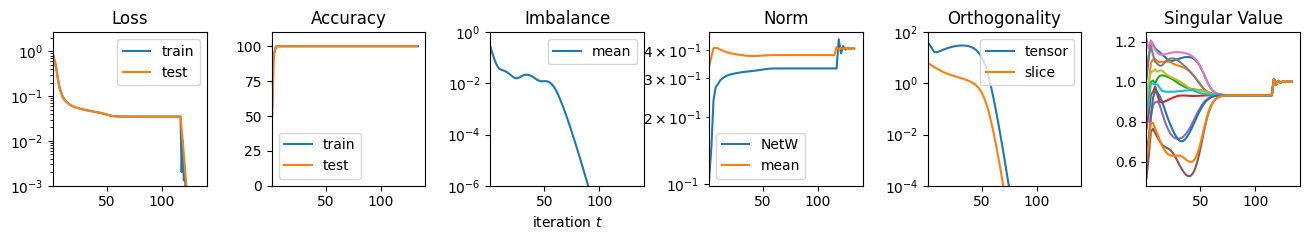

In [9]:
seed = 2
train_frac = 100
task_name = 'binary/sym3_xy'

out, save_name_sym3_100_seed2 = train(task_name, train_frac, seed=seed,  
                                      val_check_interval=1)
(model_sym3_100_seed2, datamodule_sym3_100_seed2, trainer) = out

1
test/mse_loss/sym3_xy_6/FC/SGD momentum=0.5 customL2/lr=0.25 wd=0.1/seed2/frac=100.0


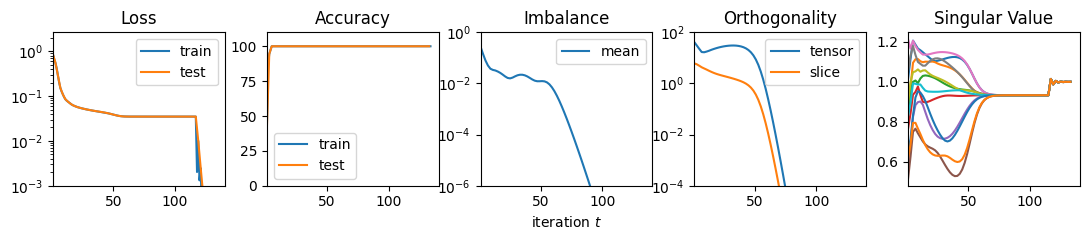

/Users/manos/Downloads/product-groups-main/notebooks/lightning_logs/test/mse_loss/sym3_xy_6/FC/SGD momentum=0.5 customL2/lr=0.25 wd=0.1/seed2/frac=100.0/version_22


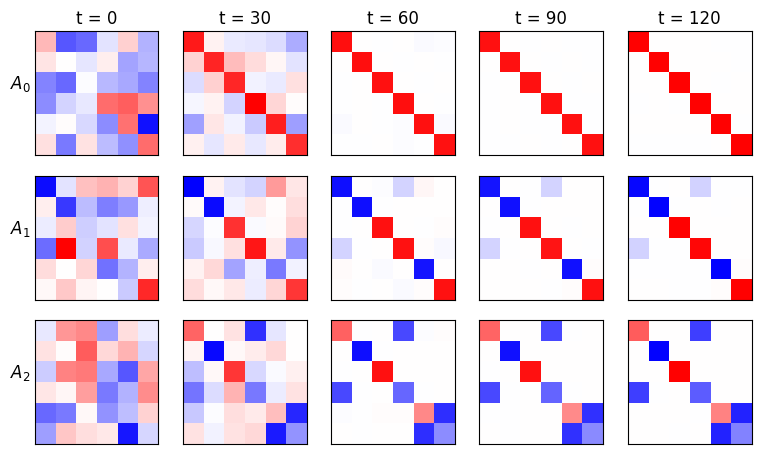

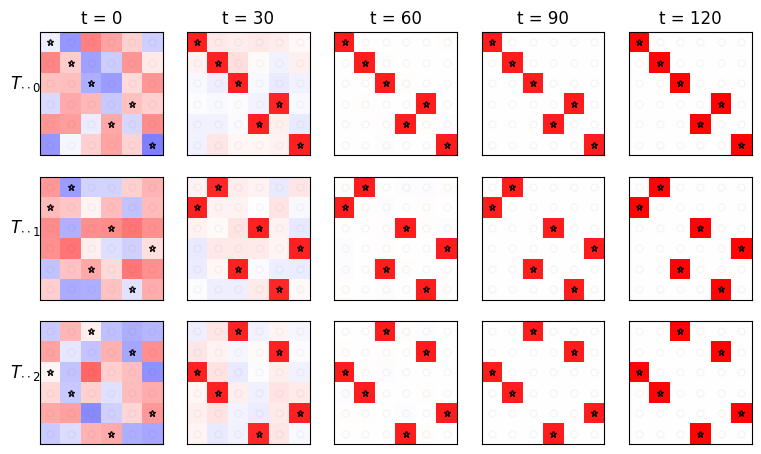

In [10]:
XYZ_sym3_100_seed2 = generate_figures(model_sym3_100_seed2, datamodule_sym3_100_seed2, save_name_sym3_100_seed2, 
                                                             skip=3, t_init=1, new_order=[2,4,5,3,1,0])    


##### no regularization

In [11]:
# seed = 2
# train_frac = 100
# task_name = 'binary/sym3_xy'

# out, save_name_sym3_100_seed2_noReg = train(task_name, train_frac, seed=seed,  val_check_interval=1, no_regularization=True)
# (model_sym3_100_seed2_noReg, datamodule_sym3_100_seed2_noReg, trainer) = out

In [12]:
_ = generate_figures(model_sym3_100_seed2_noReg, datamodule_sym3_100_seed2_noReg, save_name_sym3_100_seed2_noReg, 
                                                  skip=1, t_init=1, XYZ_prev=XYZ_sym3_100_seed2, new_order=None)


NameError: name 'model_sym3_100_seed2_noReg' is not defined

#### 61% 

##### R regularization

train dataset size: 44 val dataset size: 28 ratio: 0.6111111111111112 %


/Users/manos/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

1
test/mse_loss/binary/sym3_xy_vec_6/FC/SGD momentum=0.5 customL2/lr=0.25 wd=0.1/seed2/frac=61.0


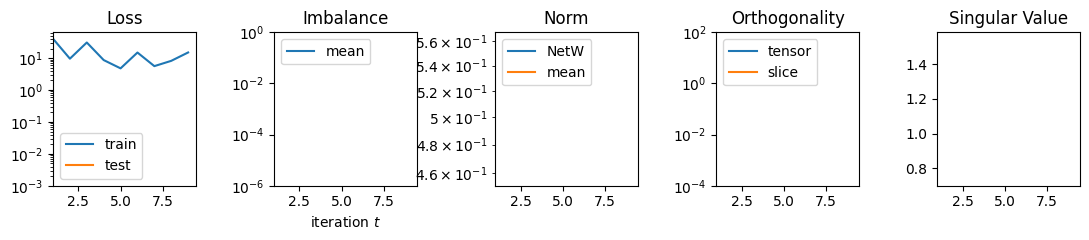

In [10]:
seed = 2
train_frac = 61
task_name = 'binary/sym3_xy_vec'

# change task name to '*_vec' to get a vectorized version

out, save_name_sym3_61_seed2 = train(task_name, train_frac, seed=seed,  val_check_interval=5, no_regularization=False)
(model_sym3_61_seed2, datamodule_sym3_61_seed2, trainer) = out

1
test/mse_loss/binary/sym3_xy_vec_6/FC/SGD momentum=0.5 customL2/lr=0.25 wd=0.1/seed2/frac=61.0


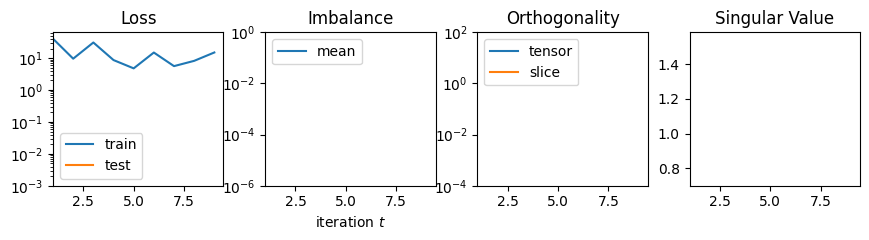

RuntimeError: Tensors must have same number of dimensions: got 2 and 3

In [11]:
XYZ_sym3_61_seed2 = generate_figures(model_sym3_61_seed2, datamodule_sym3_61_seed2, save_name_sym3_61_seed2, 
                                                           skip=15, t_init=0, show_steps=5, new_order=[5,4,3,2,1,0], plot_all_weights=True, ABC_or_A = 'ABC')

In [15]:
model_sym3_61_seed2.model.conv_weight

AttributeError: 'Deep_Tensor_Net' object has no attribute 'conv_weight'

In [ ]:
factor_list = model_sym3_61_seed2.model.factor_list
A = normalize_factor_list(factor_list)[0].detach()
AA = torch.einsum('aij,bjk->abik',A,A)
plot_tensor_slices2(AA,idx_name_cols=['A','A','A','A','A','A',], save_name=save_name_sym3_61_seed2, save_name_extra='A_multiplication_table')

##### L2 regularization

In [ ]:
seed = 2
train_frac = 61
task_name = 'binary/sym3_xy'

out, save_name_sym3_61_L2_seed2 = train(task_name, train_frac, seed=seed,  L2_reg=True, val_check_interval=5, no_regularization=False)#, gradient_projection=False)
(model_sym3_61_L2_seed2, datamodule_sym3_61_L2_seed2, trainer) = out

In [29]:
XYZ_sym3_61_L2_seed2 = generate_figures(model_sym3_61_L2_seed2, datamodule_sym3_61_L2_seed2, save_name_sym3_61_L2_seed2, 
                                                           skip=10, t_init=0, show_steps=5, XYZ_prev=None, normalize_1=False, new_order=None, plot_all_weights=True, ABC_or_A='ABC')    

NameError: name 'model_sym3_61_L2_seed2' is not defined

###### old run

In [30]:
XYZ_sym3_61_L2_seed2 = generate_figures(model_sym3_61_L2_seed2, datamodule_sym3_61_L2_seed2, save_name_sym3_61_L2_seed2, 
                                                           skip=15, t_init=0, show_steps=5, new_order=None, plot_all_weights=True)    

NameError: name 'model_sym3_61_L2_seed2' is not defined

##### no regularization

In [31]:
# seed = 2
# train_frac = 61
# task_name = 'binary/sym3_xy'

# out, save_name_61_seed2_noReg = train(task_name, train_frac, seed=seed,  val_check_interval=1, no_regularization=True)
# (model_sym3_61_seed2_noReg, datamodule_sym3_61_seed2_noReg, trainer) = out

In [32]:
_ = generate_figures(model_sym3_61_seed2_noReg, datamodule_sym3_61_seed2_noReg, save_name_61_seed2_noReg, 
                                                 skip=1, show_steps = 2, XYZ_prev=XYZ_sym3_61_seed2, new_order=None)


NameError: name 'model_sym3_61_seed2_noReg' is not defined

### 'binary/+', 

##### R regularization

train dataset size: 36 val dataset size: 36 ratio: 0.5 %


/Users/manos/Library/Python/3.9/lib/python/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

1
test/mse_loss/binary/+_vec_6/FC/SGD momentum=0.5 customL2/lr=0.25 wd=0.1/seed2/frac=50.0


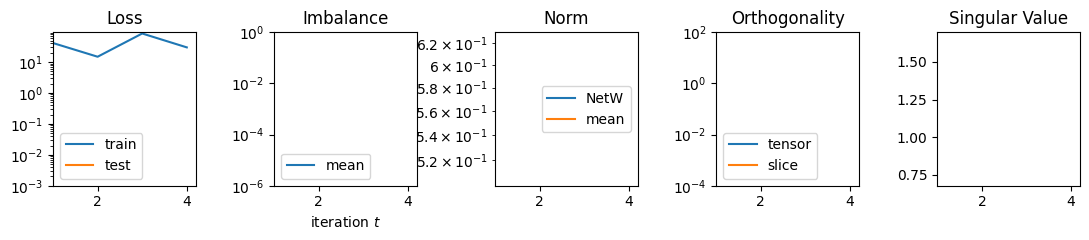

In [12]:
seed = 2
train_frac = 50
task_name = 'binary/+_vec'

# works for 50% training fraction, for 100% it has issues. Ben says that if you reduce the learning rate it should work with 100%.
out, save_name_add_100_seed2 = train(task_name, train_frac, seed=seed,  val_check_interval=2, no_regularization=False)
(model_add_100_seed2, datamodule_add_100_seed2, trainer) = out

1
test/mse_loss/binary/+_vec_6/FC/SGD momentum=0.5 customL2/lr=0.25 wd=0.1/seed2/frac=50.0


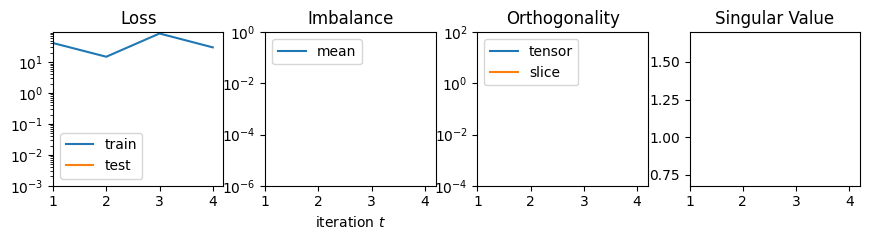

/Users/manos/Dropbox/code/repos/DeepTensorFactorization4GroupRep/notebooks/lightning_logs/test/mse_loss/binary/+_vec_6/FC/SGD momentum=0.5 customL2/lr=0.25 wd=0.1/seed2/frac=50.0/version_1


TypeError: 'Axes' object is not iterable

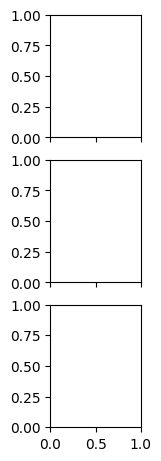

In [13]:
XYZ_add_100_seed2 = generate_figures(model_add_100_seed2, datamodule_add_100_seed2, save_name_add_100_seed2, 
                                                           skip=2, t_init=1, new_order=[5,4,3,0,1,2])


##### no regularization

scheduler_criterion imbalance2/mean
train dataset size: 36 val dataset size: 36 ratio: 0.5 %
current_step: 0 , max_step: 2500 , schedule: [0, 0, 0, 2500, 0]


Sanity Checking: 0it [00:00, ?it/s]

/Users/huh/Projects/grok/grok/alt_opt.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_shape = torch.max(torch.tensor(max_shape), torch.tensor(a.shape))


Training: 0it [00:00, ?it/s]

1
test/Lagrange/addition_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5/seed2/frac=100.0


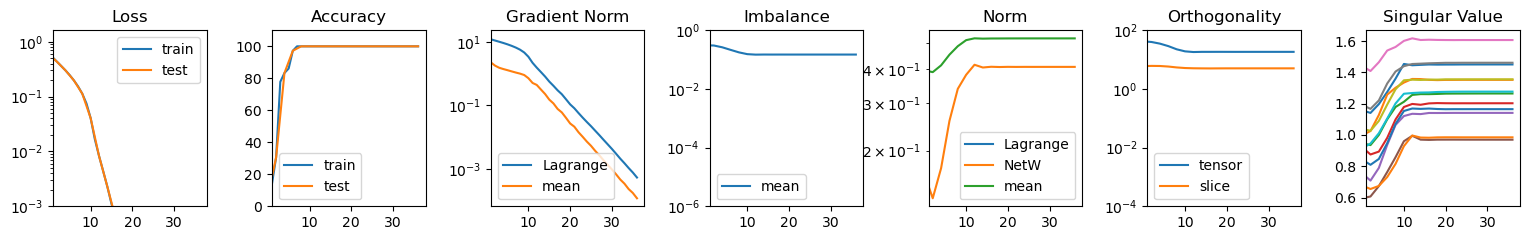

In [306]:
# seed = 2
# train_frac = 100
# task_name = 'binary/+'

# out, save_name_add_100_seed2_noReg = train(task_name, train_frac, seed=seed,  val_check_interval=1, no_regularization=True)
# (model_add_100_seed2_noReg, datamodule_add_100_seed2_noReg, trainer) = out

1
test/Lagrange/addition_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5/seed2/frac=100.0


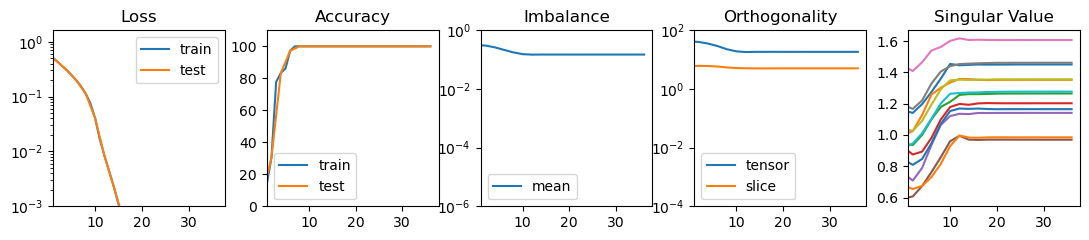

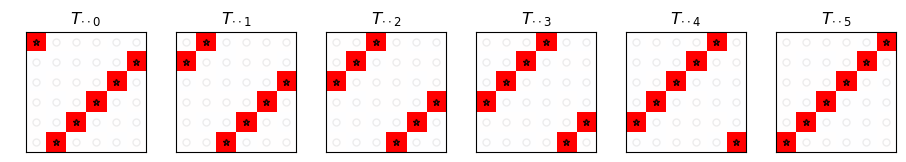

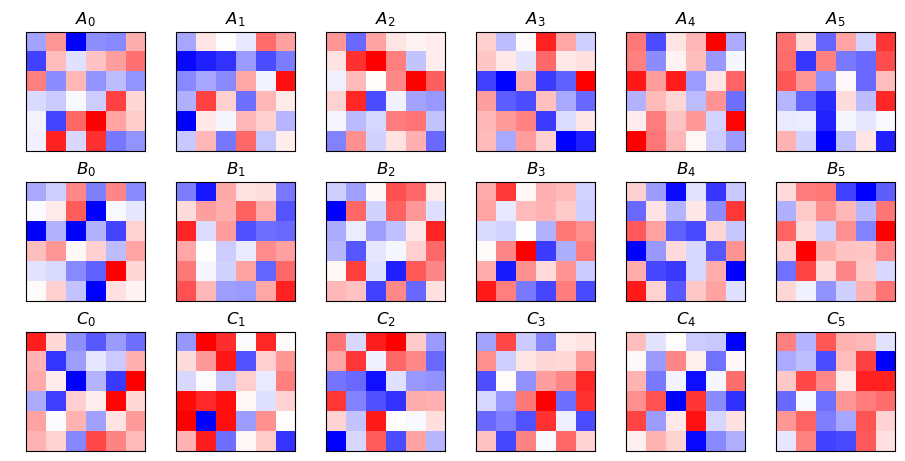

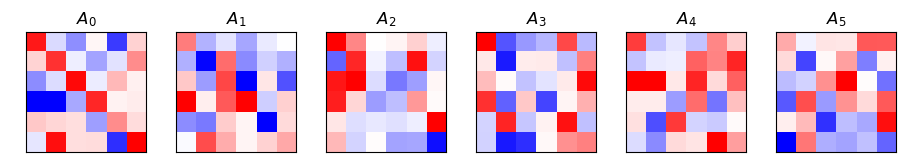

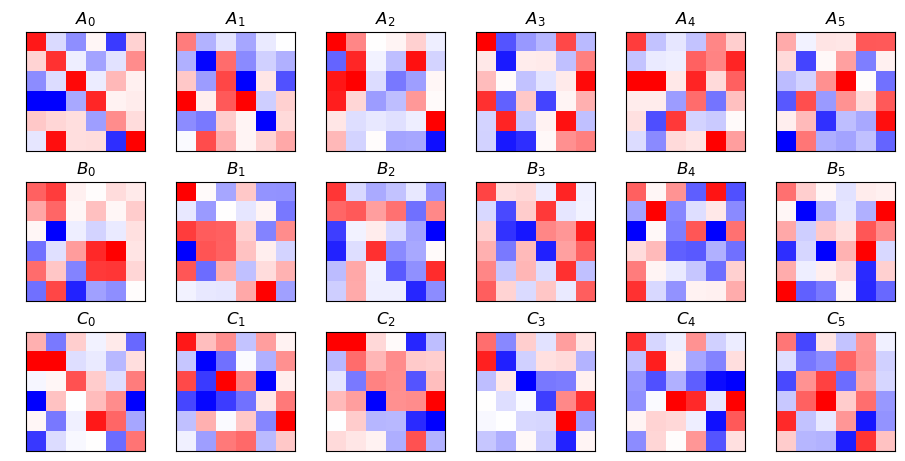

/Users/huh/Projects/grok/scripts/lightning_logs/test/Lagrange/addition_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5/seed2/frac=100.0/version_5


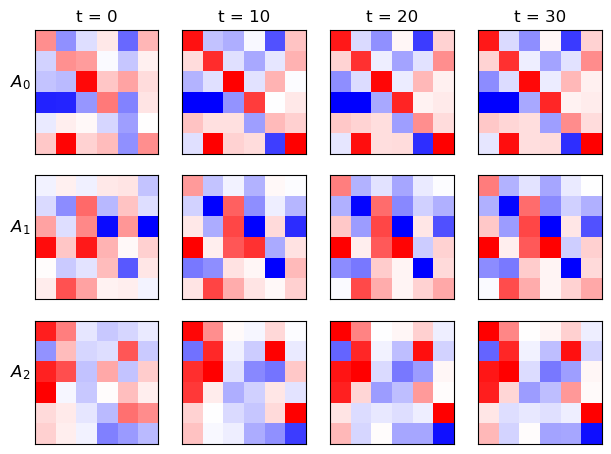

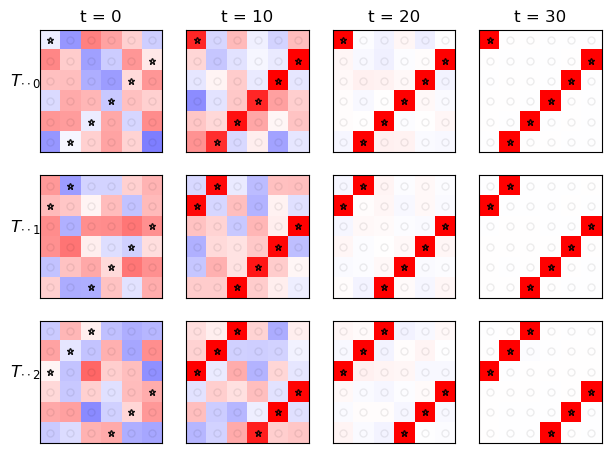

/Users/huh/Projects/grok/scripts/lightning_logs/test/Lagrange/addition_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5/seed2/frac=100.0/version_5


In [319]:
_ = generate_figures(model_add_100_seed2_noReg, datamodule_add_100_seed2_noReg, save_name_add_100_seed2_noReg, 
                                                 skip=1, XYZ_prev=XYZ_add_100_seed2, new_order=None)

#### 60%

##### R regularization

train dataset size: 22 val dataset size: 14 ratio: 0.6111111111111112 %
Epoch 1182: 100%|████████████████████████████████████████████████████| 1/1 [00:00<00:00, 34.91it/s, loss/train=1e-7, loss/val=3.12e-6, imbalance2/mean=0.00349]
1
test/mse_loss/addition_6/FC/SGD momentum=0.5 customL2/lr=0.25 wd=0.1/seed2/frac=61.0
Epoch 0:   0%|                                                                                                                           | 0/1 [31:17<?, ?it/s]


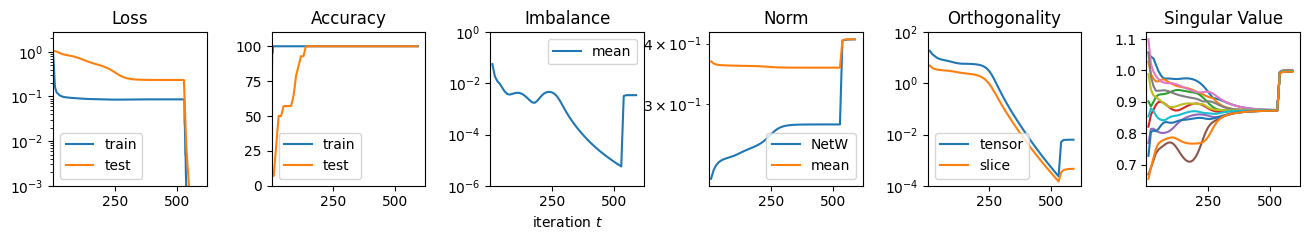

In [38]:
seed = 2
train_frac = 61
task_name = 'binary/+'

out, save_name_add_61_seed2 = train(task_name, train_frac, seed=seed,  val_check_interval=5)
(model_add_61_seed2, datamodule_add_61_seed2, trainer) = out

1
test/mse_loss/addition_6/FC/SGD momentum=0.5 customL2/lr=0.25 wd=0.1/seed2/frac=61.0


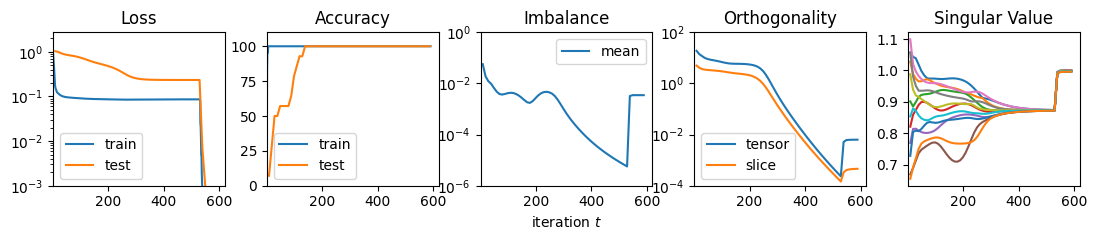

/Users/huh/Projects/DeepTensorFactorization4GroupRep/notebooks/lightning_logs/test/mse_loss/addition_6/FC/SGD momentum=0.5 customL2/lr=0.25 wd=0.1/seed2/frac=61.0/version_5


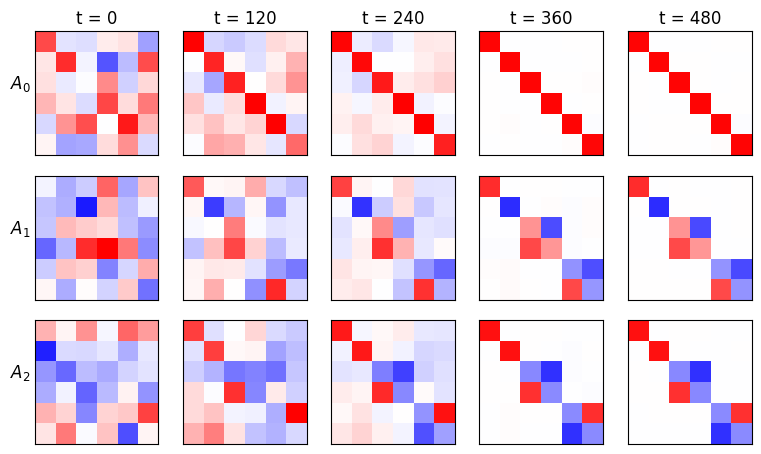

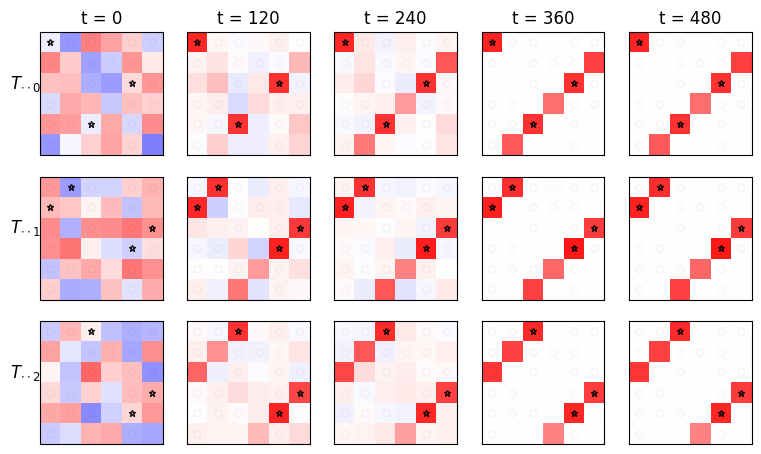

In [39]:
XYZ_add_61_seed2 = generate_figures(model_add_61_seed2, datamodule_add_61_seed2, save_name_add_61_seed2, 
                                                         skip=12, t_init=0, XYZ_prev=None, new_order=[5,3,0,1,2,4])


##### no regularization

scheduler_criterion imbalance2/mean
train dataset size: 22 val dataset size: 14 ratio: 0.6111111111111112 %
current_step: 0 , max_step: 2500 , schedule: [0, 0, 0, 2500, 0]


Sanity Checking: 0it [00:00, ?it/s]

/Users/huh/Projects/grok/grok/alt_opt.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_shape = torch.max(torch.tensor(max_shape), torch.tensor(a.shape))


Training: 0it [00:00, ?it/s]

1
test/Lagrange/addition_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5/seed2/frac=61.0


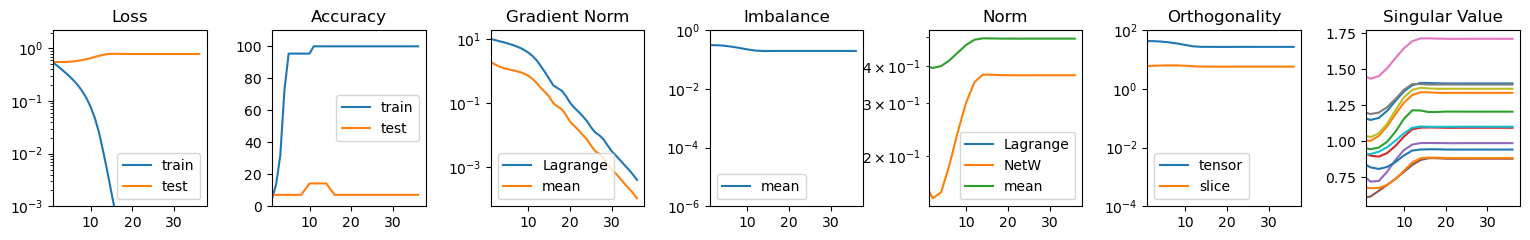

In [310]:
# seed = 2
# train_frac = 61
# task_name = 'binary/+'

# out, save_name_add_61_seed2_noReg = train(task_name, train_frac, seed=seed,  val_check_interval=1, no_regularization=True)
# (model_add_61_seed2_noReg, datamodule_add_61_seed2_noReg, trainer) = out

1
test/Lagrange/addition_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5/seed2/frac=61.0


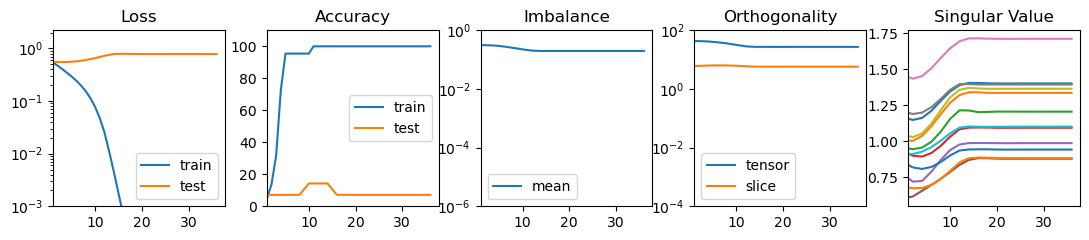

/Users/huh/Projects/grok/scripts/lightning_logs/test/Lagrange/addition_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5/seed2/frac=61.0/version_2


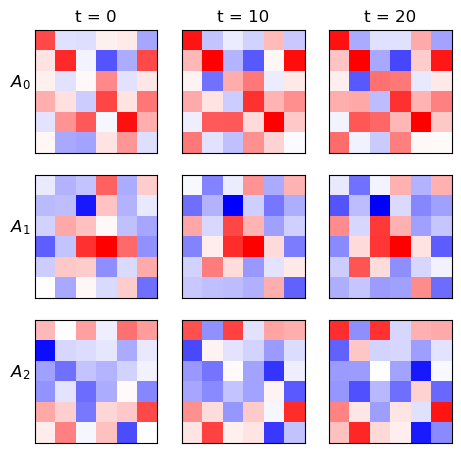

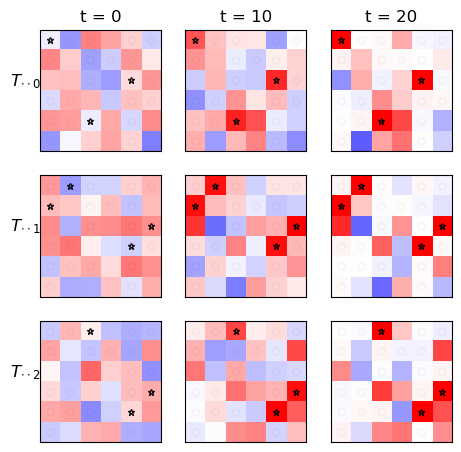

/Users/huh/Projects/grok/scripts/lightning_logs/test/Lagrange/addition_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5/seed2/frac=61.0/version_2


In [345]:
_ = generate_figures(model_add_61_seed2_noReg, datamodule_add_61_seed2_noReg, save_name_add_61_seed2_noReg, 
                                                skip=1, show_steps = 2, XYZ_prev=XYZ_add_61_seed2, new_order=None)

### 'binary/-', 

#### 100% 

##### R regularization

scheduler_criterion imbalance2/mean
train dataset size: 36 val dataset size: 36 ratio: 0.5 %


Missing logger folder: /Users/huh/Projects/grok/scripts/lightning_logs/test/Lagrange/subtraction_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5 wd=0.1/seed2/frac=100.0


current_step: 0 , max_step: 2500 , schedule: [0, 0, 0, 2500, 0]


Sanity Checking: 0it [00:00, ?it/s]

/Users/huh/Projects/grok/grok/alt_opt.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_shape = torch.max(torch.tensor(max_shape), torch.tensor(a.shape))


Training: 0it [00:00, ?it/s]

1
test/Lagrange/subtraction_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5 wd=0.1/seed2/frac=100.0


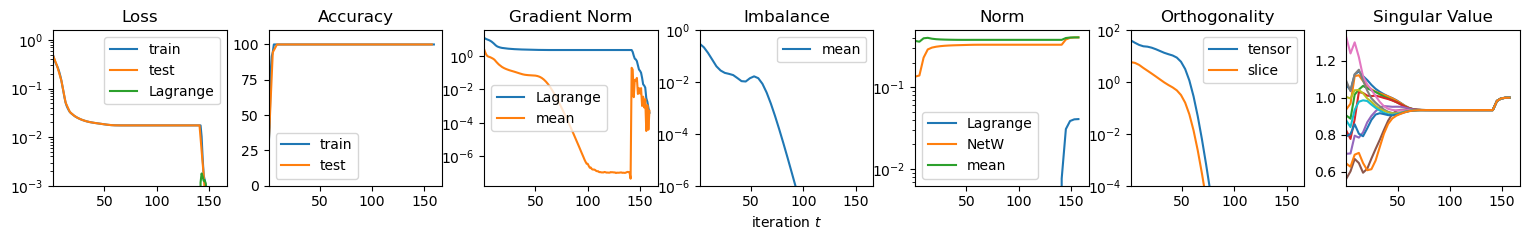

In [25]:
seed = 2
train_frac = 100
task_name = 'binary/-'

out, save_name_subtract_100_seed2 = train(task_name, train_frac, seed=seed,  val_check_interval=2, no_regularization=False)
(model_subtract_100_seed2, datamodule_subtract_100_seed2, trainer) = out

1
test/Lagrange/subtraction_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5 wd=0.1/seed2/frac=100.0


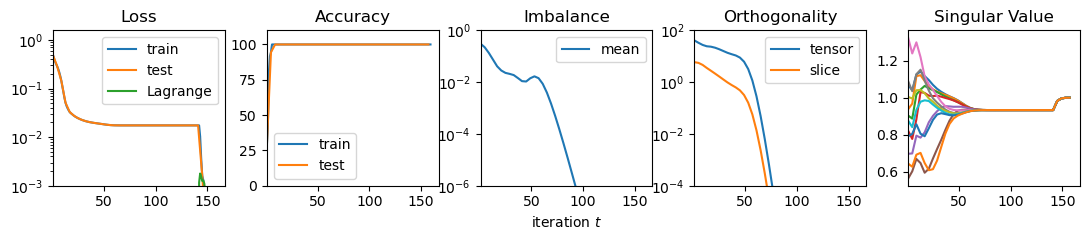

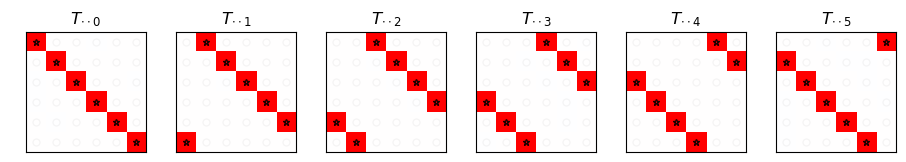

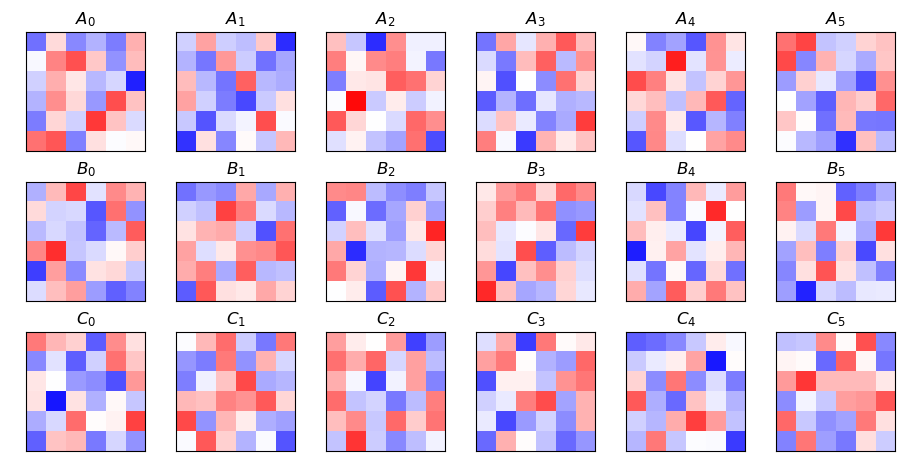

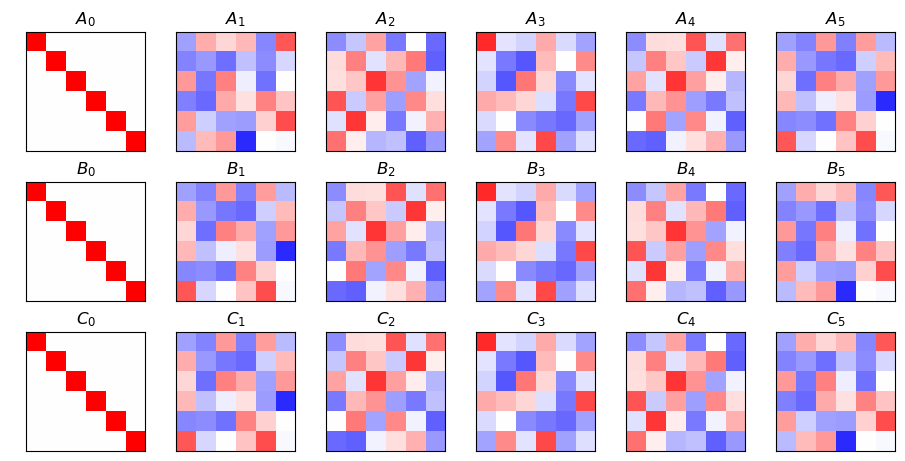

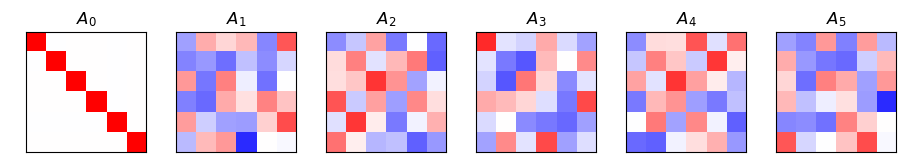

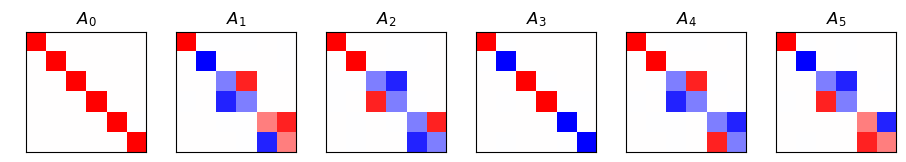

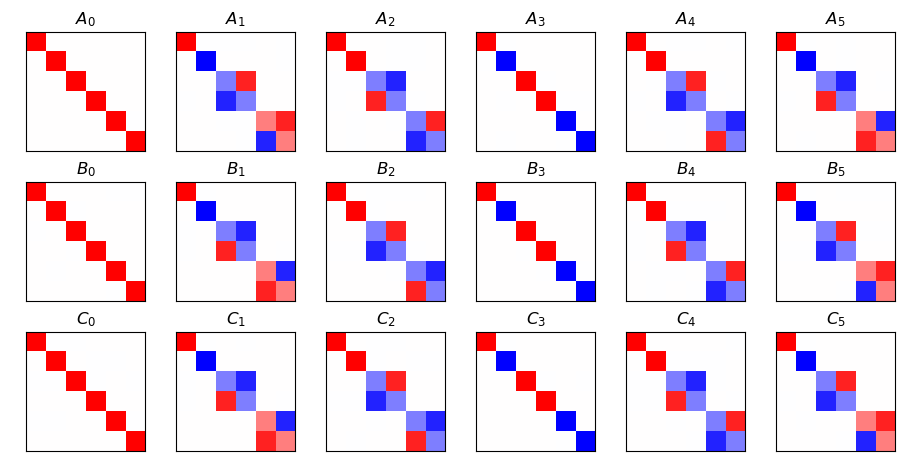

/Users/huh/Projects/grok/scripts/lightning_logs/test/Lagrange/subtraction_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5 wd=0.1/seed2/frac=100.0/version_0


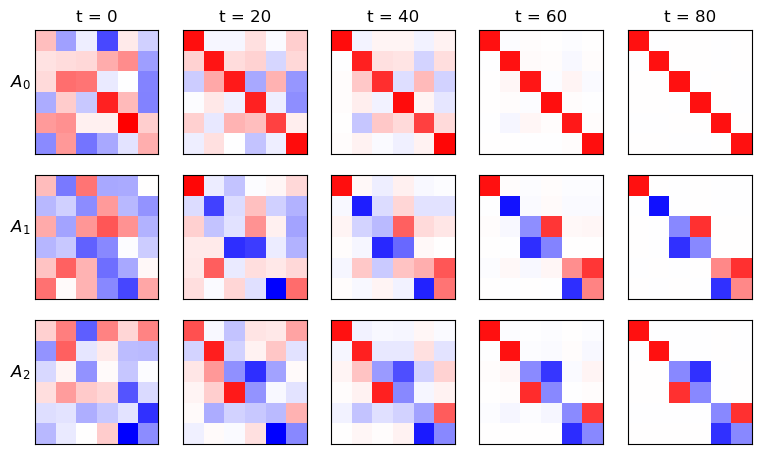

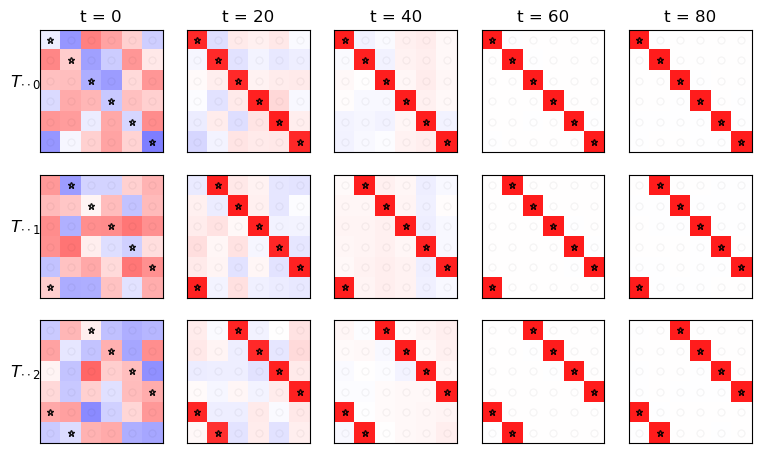

/Users/huh/Projects/grok/scripts/lightning_logs/test/Lagrange/subtraction_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5 wd=0.1/seed2/frac=100.0/version_0


In [42]:
XYZ_subtract_100_seed2 = generate_figures(model_subtract_100_seed2, datamodule_subtract_100_seed2, save_name_subtract_100_seed2, 
                                                           skip=2, t_init=1, new_order=[2,1,0,3,4,5])


##### no regularization

Missing logger folder: /Users/huh/Projects/grok/scripts/lightning_logs/test/Lagrange/subtraction_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5/seed2/frac=100.0


scheduler_criterion imbalance2/mean
train dataset size: 36 val dataset size: 36 ratio: 0.5 %
current_step: 0 , max_step: 2500 , schedule: [0, 0, 0, 2500, 0]


Sanity Checking: 0it [00:00, ?it/s]

/Users/huh/Projects/grok/grok/alt_opt.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_shape = torch.max(torch.tensor(max_shape), torch.tensor(a.shape))


Training: 0it [00:00, ?it/s]

1
test/Lagrange/subtraction_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5/seed2/frac=100.0


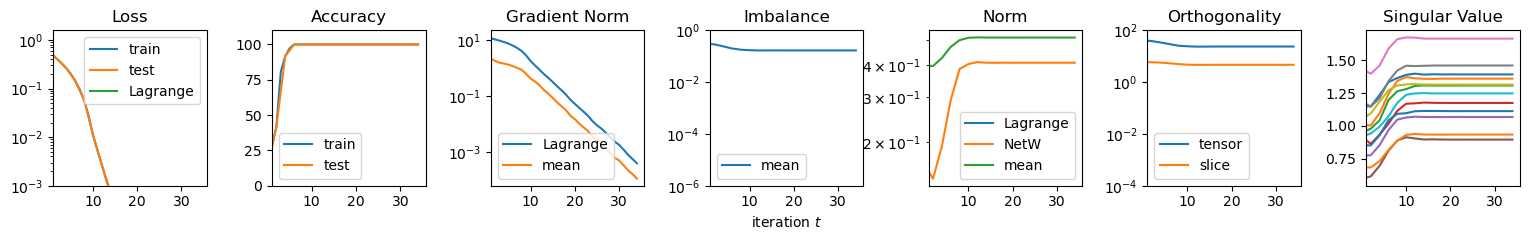

In [27]:
seed = 2
train_frac = 100
task_name = 'binary/-'

out, save_name_subtract_100_seed2_noReg = train(task_name, train_frac, seed=seed,  val_check_interval=1, no_regularization=True)
(model_subtract_100_seed2_noReg, datamodule_subtract_100_seed2_noReg, trainer) = out

1
test/Lagrange/subtraction_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5/seed2/frac=100.0


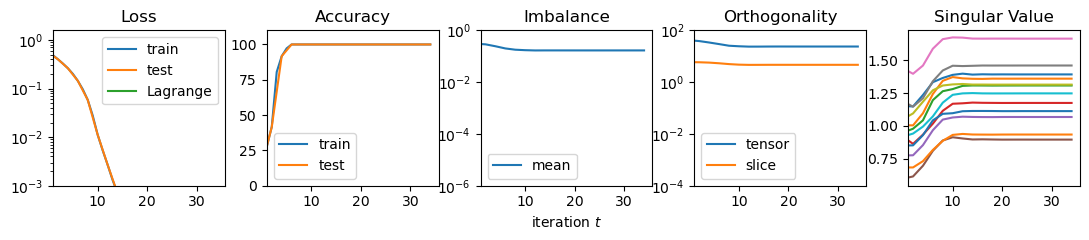

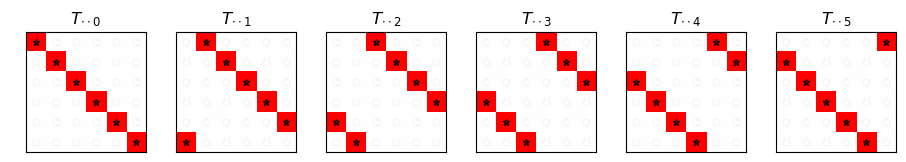

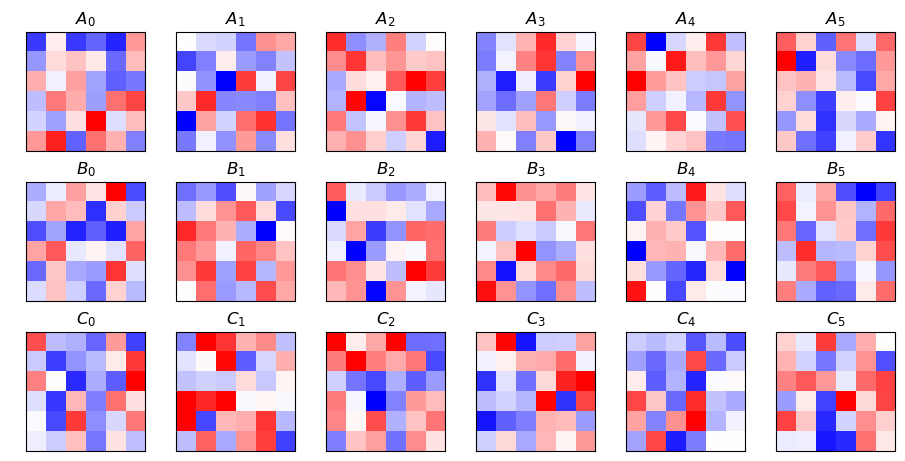

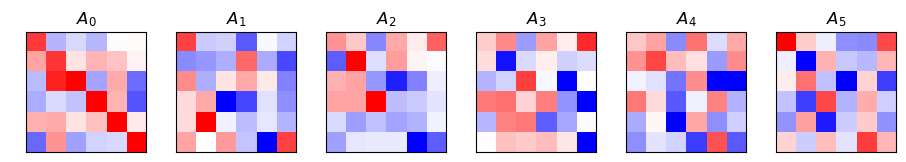

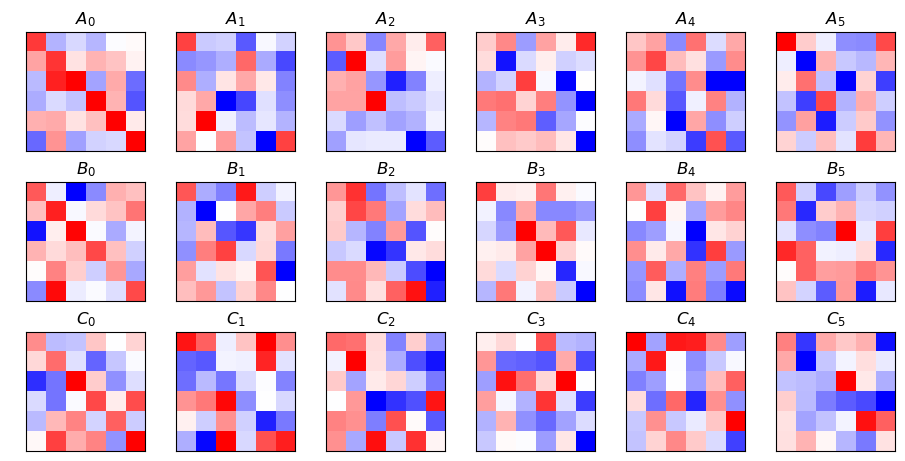

/Users/huh/Projects/grok/scripts/lightning_logs/test/Lagrange/subtraction_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5/seed2/frac=100.0/version_0


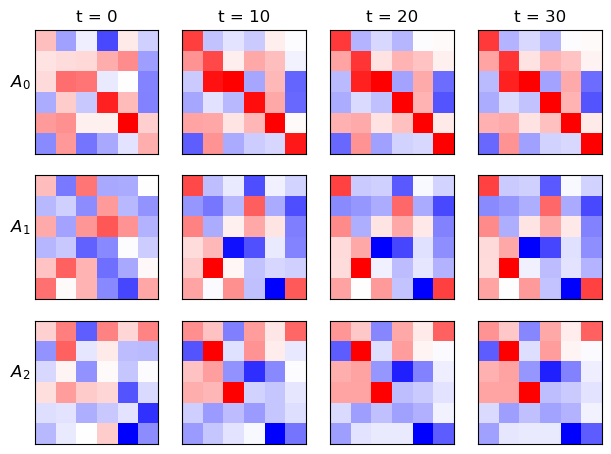

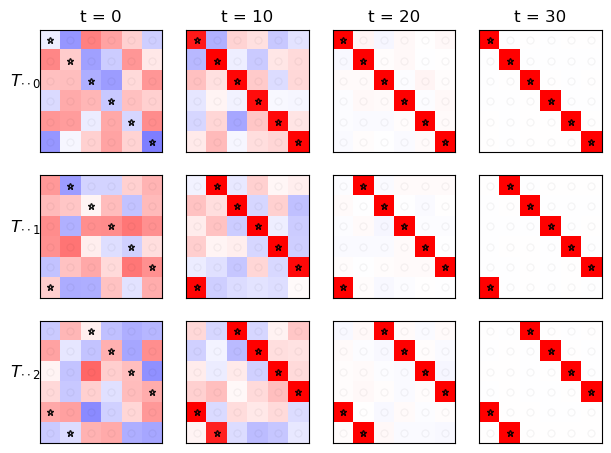

/Users/huh/Projects/grok/scripts/lightning_logs/test/Lagrange/subtraction_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5/seed2/frac=100.0/version_0


In [43]:
_ = generate_figures(model_subtract_100_seed2_noReg, datamodule_subtract_100_seed2_noReg, save_name_subtract_100_seed2_noReg, 
                                                 skip=1, XYZ_prev=XYZ_subtract_100_seed2, new_order=None)

#### 60%

##### R regularization

Missing logger folder: /Users/huh/Projects/grok/scripts/lightning_logs/test/Lagrange/subtraction_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5 wd=0.1/seed2/frac=61.0


scheduler_criterion imbalance2/mean
train dataset size: 22 val dataset size: 14 ratio: 0.6111111111111112 %
current_step: 0 , max_step: 2500 , schedule: [0, 0, 0, 2500, 0]


Sanity Checking: 0it [00:00, ?it/s]

/Users/huh/Projects/grok/grok/alt_opt.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_shape = torch.max(torch.tensor(max_shape), torch.tensor(a.shape))


Training: 0it [00:00, ?it/s]

1
test/Lagrange/subtraction_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5 wd=0.1/seed2/frac=61.0


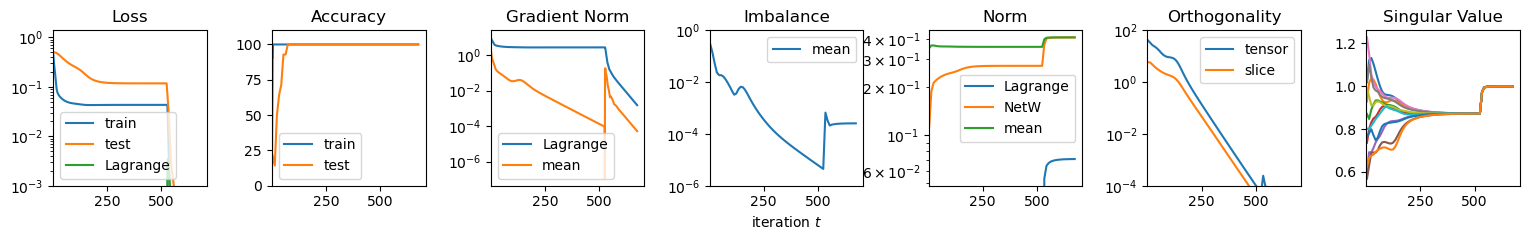

In [29]:
seed = 2
train_frac = 61
task_name = 'binary/-'

out, save_name_subtract_61_seed2 = train(task_name, train_frac, seed=seed,  val_check_interval=5)
(model_subtract_61_seed2, datamodule_subtract_61_seed2, trainer) = out

1
test/Lagrange/subtraction_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5 wd=0.1/seed2/frac=61.0


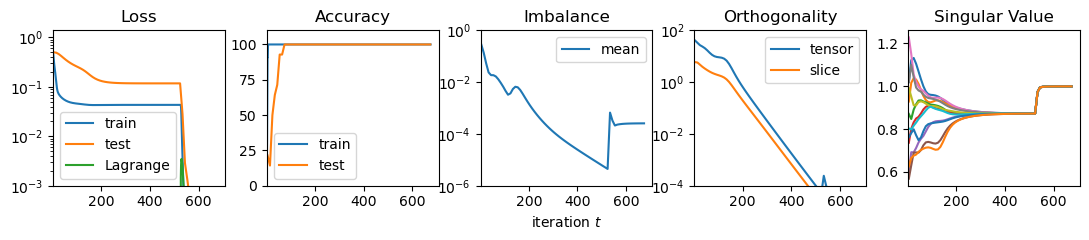

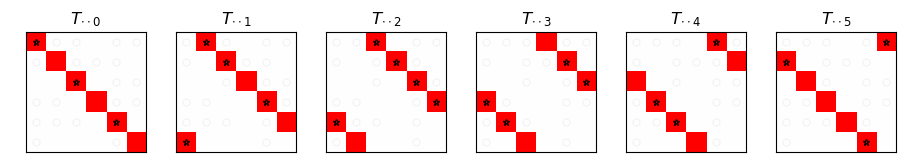

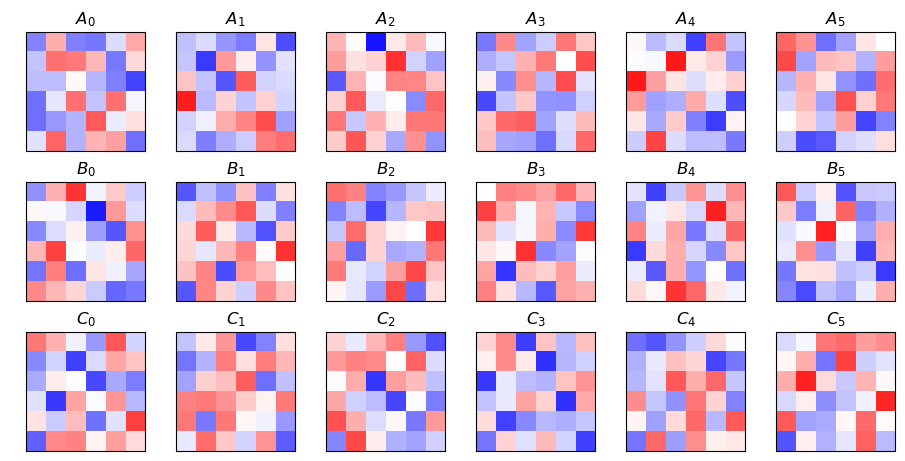

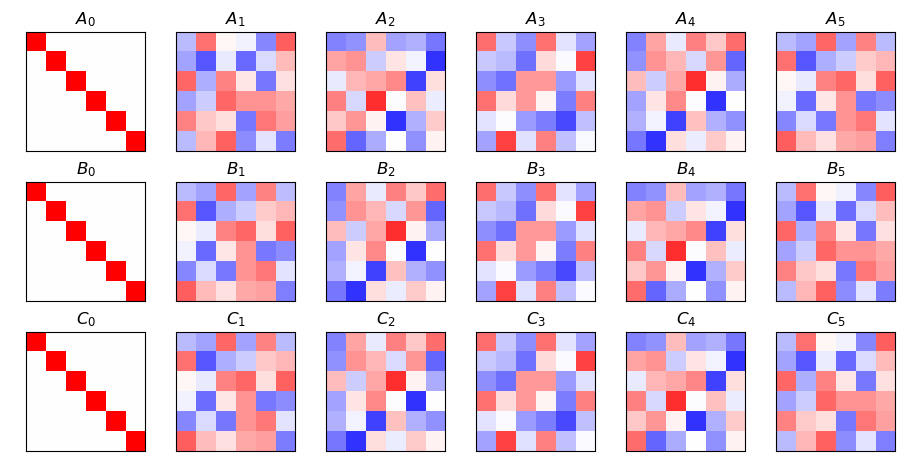

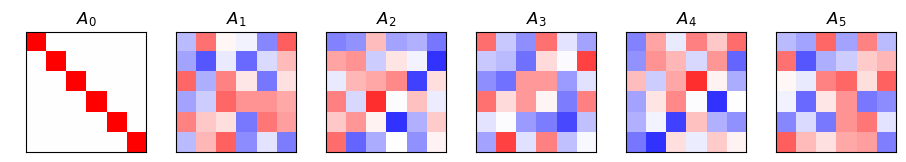

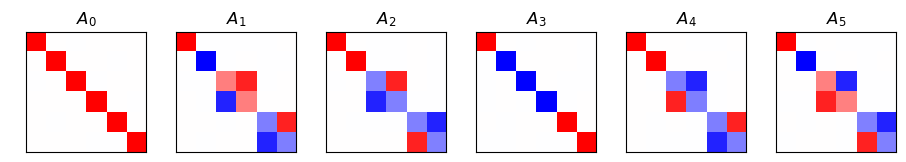

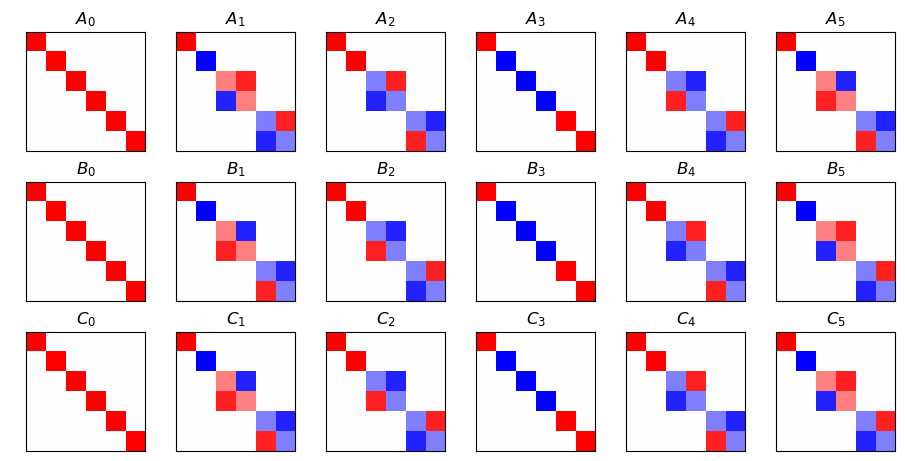

/Users/huh/Projects/grok/scripts/lightning_logs/test/Lagrange/subtraction_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5 wd=0.1/seed2/frac=61.0/version_0


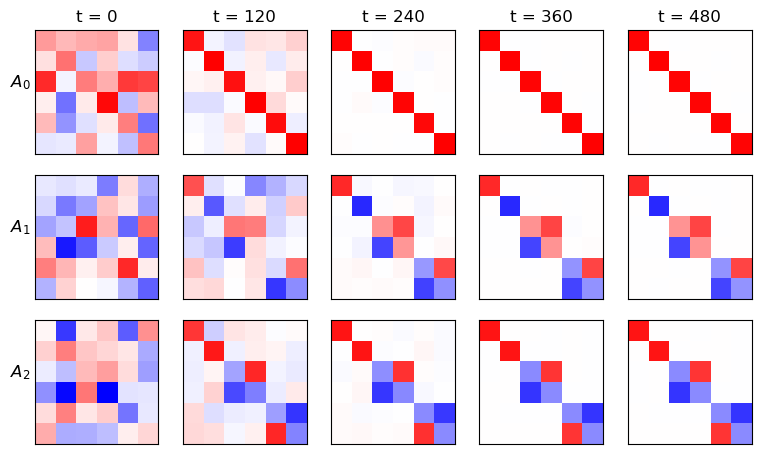

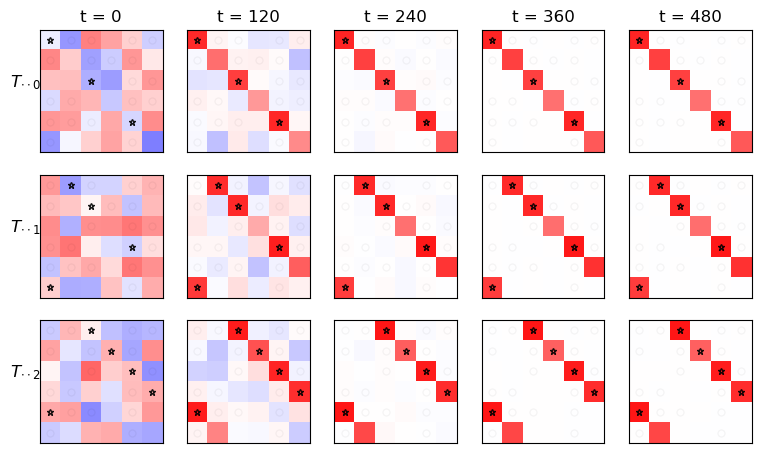

/Users/huh/Projects/grok/scripts/lightning_logs/test/Lagrange/subtraction_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5 wd=0.1/seed2/frac=61.0/version_0


In [44]:
XYZ_subtract_61_seed2 = generate_figures(model_subtract_61_seed2, datamodule_subtract_61_seed2, save_name_subtract_61_seed2, 
                                                         skip=12, t_init=0, XYZ_prev=None, new_order=[2,5,3,4,0,1])


##### no regularization

scheduler_criterion imbalance2/mean
train dataset size: 22 val dataset size: 14 ratio: 0.6111111111111112 %
current_step: 0 , max_step: 2500 , schedule: [0, 0, 0, 2500, 0]


Sanity Checking: 0it [00:00, ?it/s]

/Users/huh/Projects/grok/grok/alt_opt.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_shape = torch.max(torch.tensor(max_shape), torch.tensor(a.shape))


Training: 0it [00:00, ?it/s]

1
test/Lagrange/subtraction_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5/seed2/frac=61.0


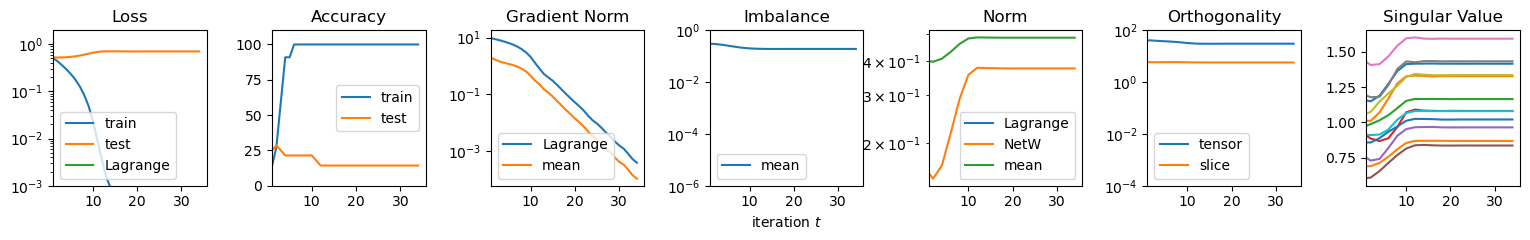

In [45]:
seed = 2
train_frac = 61
task_name = 'binary/-'

out, save_name_subtract_61_seed2_noReg = train(task_name, train_frac, seed=seed,  val_check_interval=1, no_regularization=True)
(model_subtract_61_seed2_noReg, datamodule_subtract_61_seed2_noReg, trainer) = out

1
test/Lagrange/subtraction_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5/seed2/frac=61.0


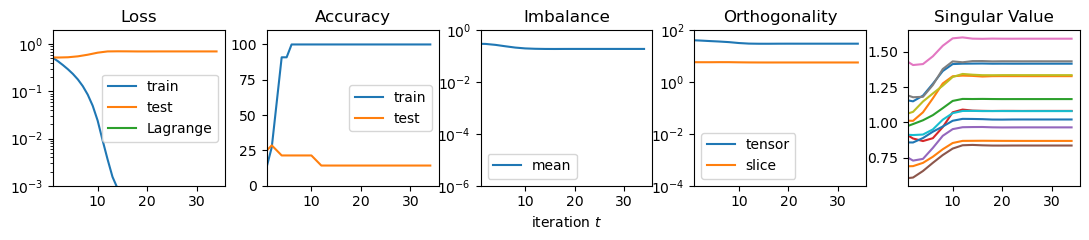

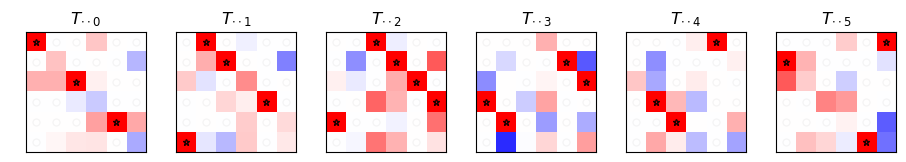

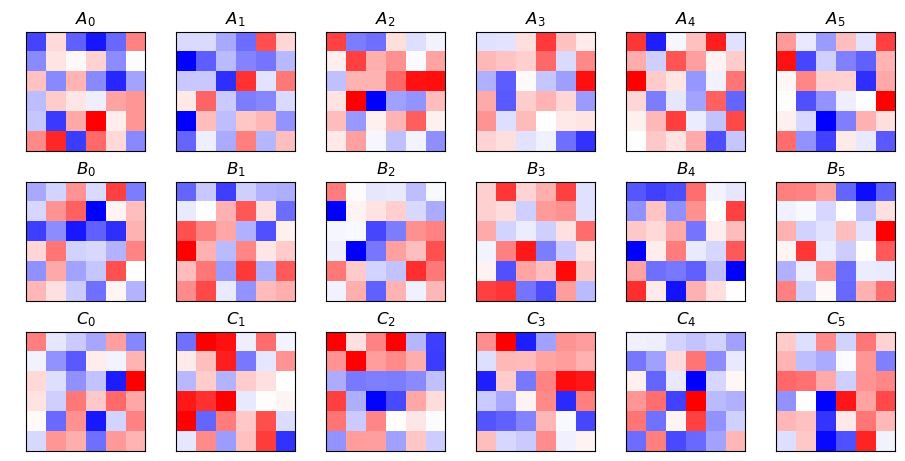

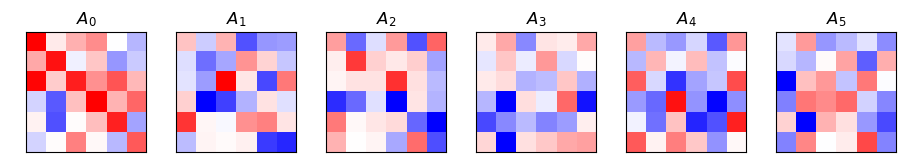

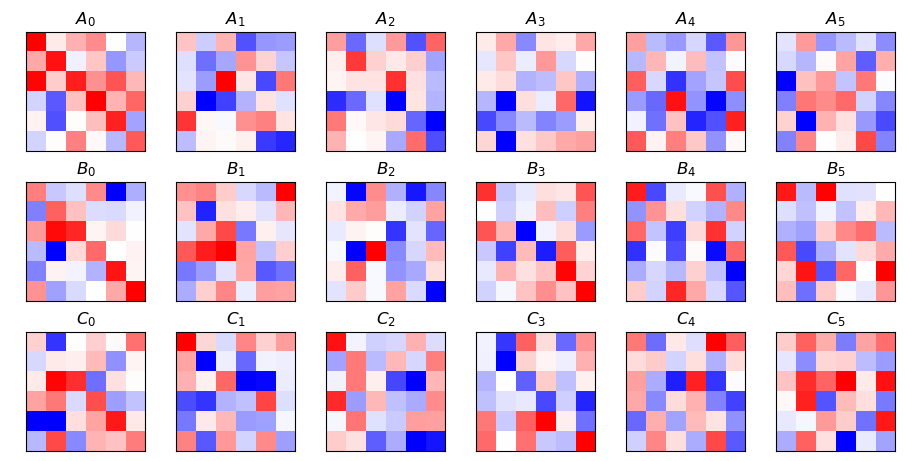

/Users/huh/Projects/grok/scripts/lightning_logs/test/Lagrange/subtraction_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5/seed2/frac=61.0/version_1


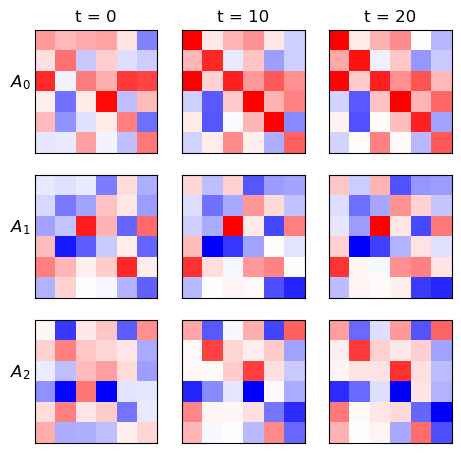

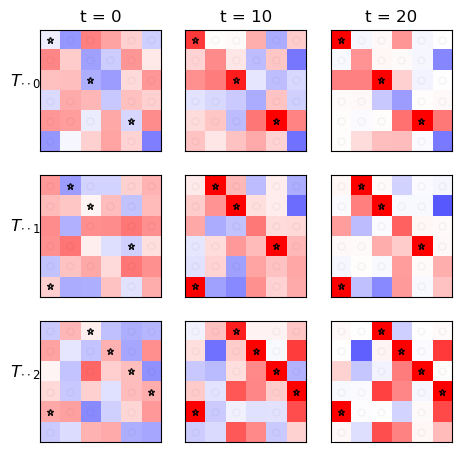

/Users/huh/Projects/grok/scripts/lightning_logs/test/Lagrange/subtraction_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5/seed2/frac=61.0/version_1


In [46]:
_ = generate_figures(model_subtract_61_seed2_noReg, datamodule_subtract_61_seed2_noReg, save_name_subtract_61_seed2_noReg, 
                                                skip=1, show_steps = 2, XYZ_prev=XYZ_subtract_61_seed2, new_order=None)

### 'binary/x**2+y**2_mod', 

#### 100% 

##### R regularization

Missing logger folder: /Users/huh/Projects/grok/scripts/lightning_logs/test/Lagrange/quad1_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5 wd=0.1/seed1/frac=100.0


scheduler_criterion imbalance2/mean
train dataset size: 36 val dataset size: 36 ratio: 0.5 %
current_step: 0 , max_step: 2500 , schedule: [0, 0, 0, 2500, 0]


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

1
test/Lagrange/quad1_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5 wd=0.1/seed1/frac=100.0


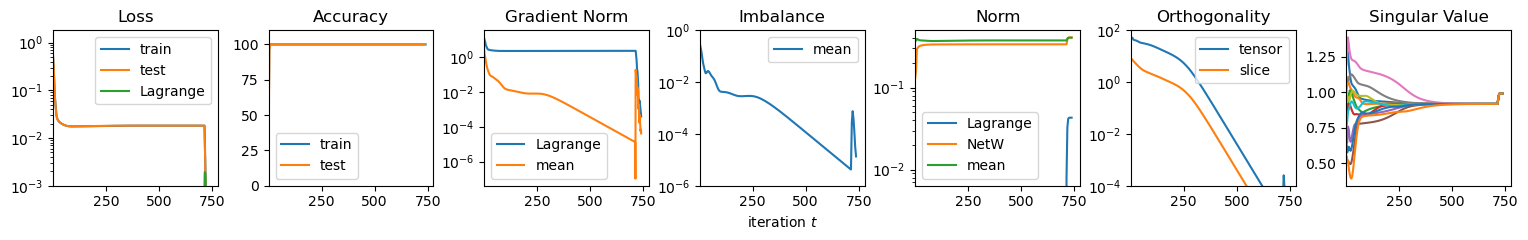

In [52]:
seed = 1
train_frac = 100
task_name = 'binary/x**2+y**2_mod'

out, save_name_quad1_100_seed1 = train(task_name, train_frac, seed=seed,  val_check_interval=2, no_regularization=False)
(model_quad1_100_seed1, datamodule_quad1_100_seed1, trainer) = out

1
test/Lagrange/quad1_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5 wd=0.1/seed1/frac=100.0


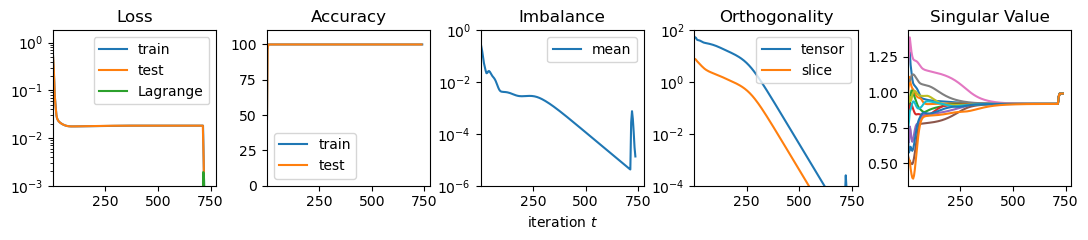

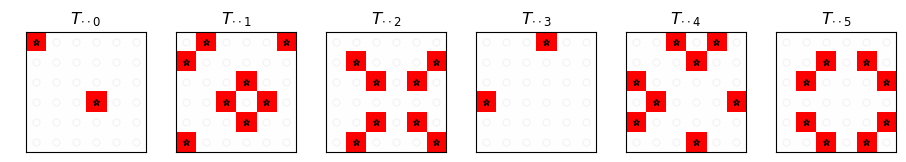

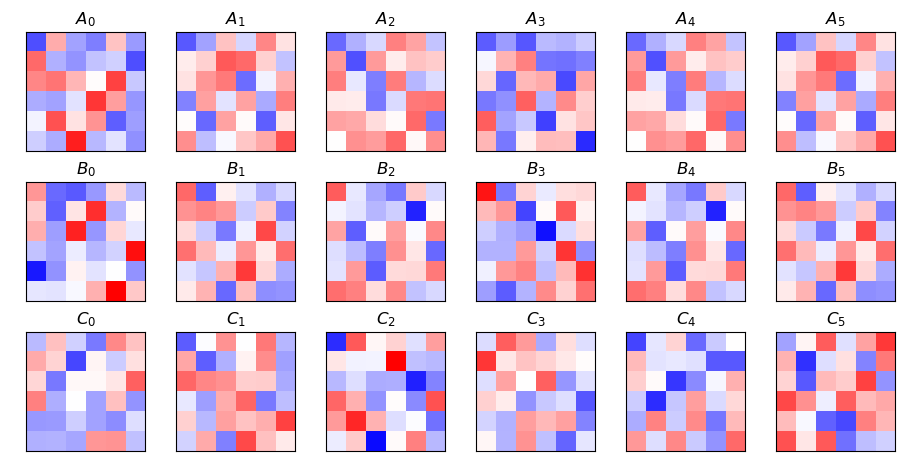

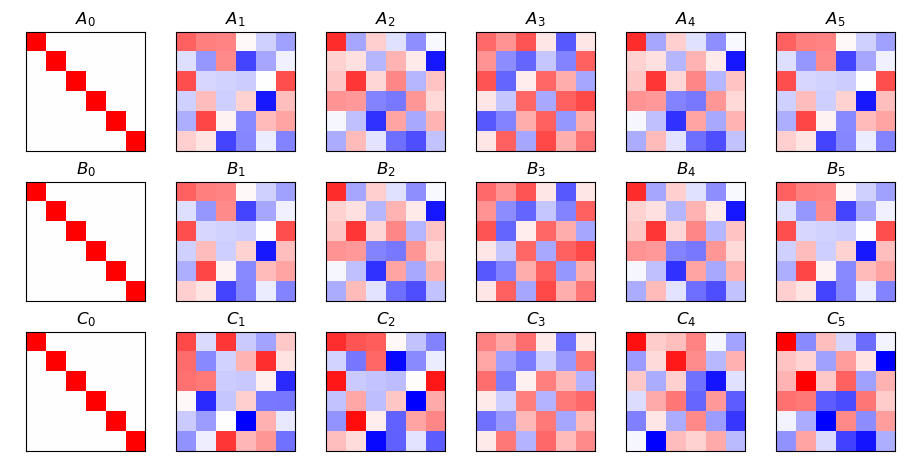

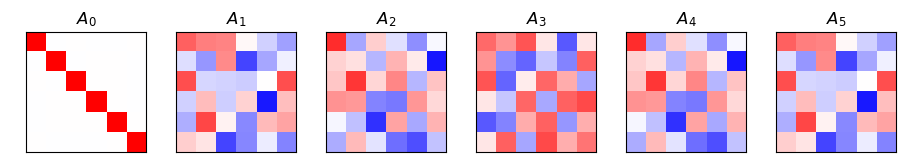

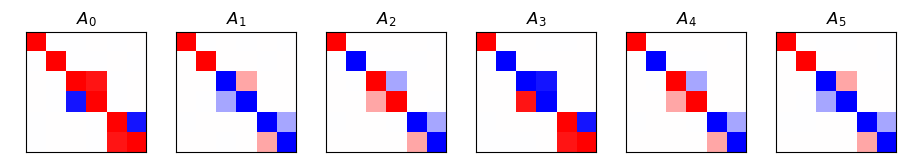

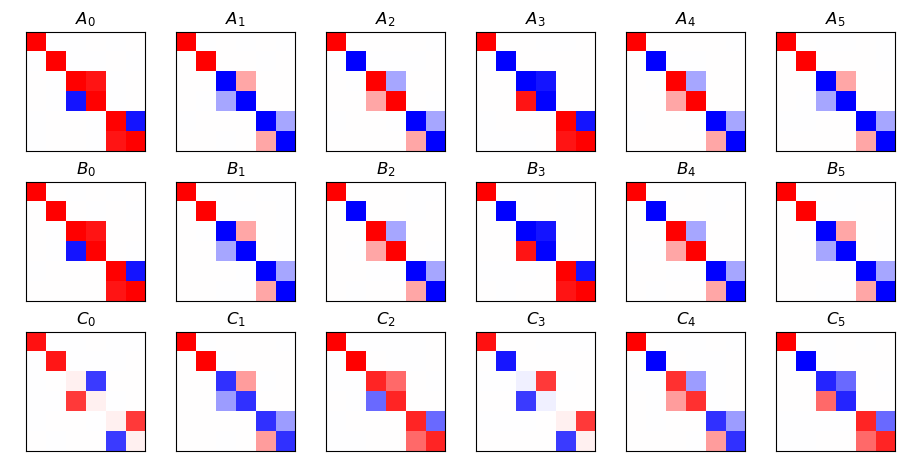

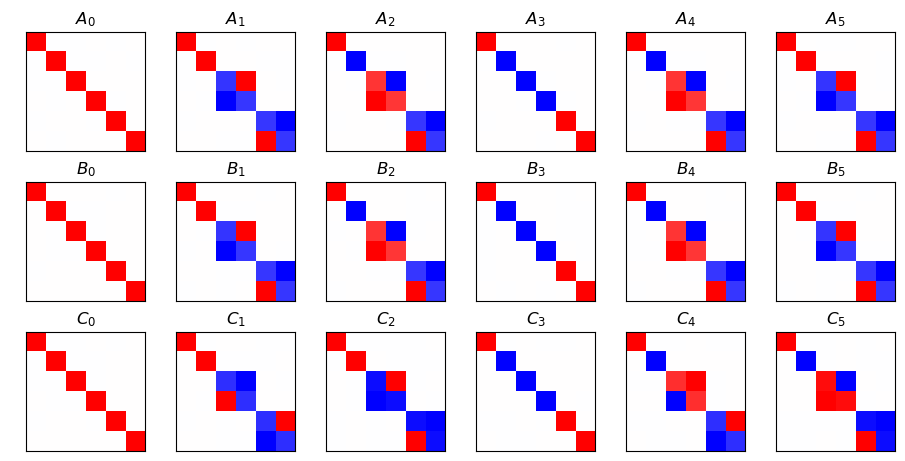

/Users/huh/Projects/grok/scripts/lightning_logs/test/Lagrange/quad1_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5 wd=0.1/seed1/frac=100.0/version_0


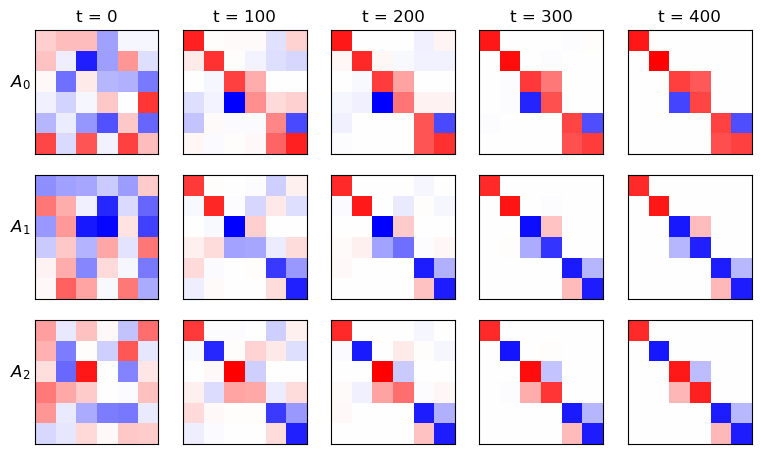

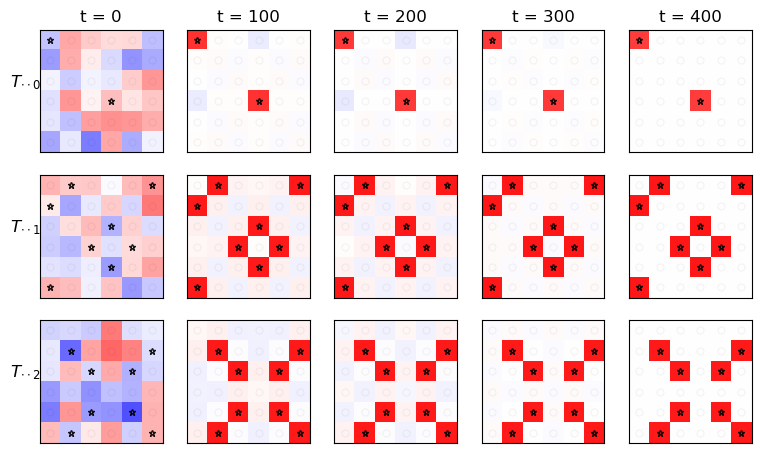

/Users/huh/Projects/grok/scripts/lightning_logs/test/Lagrange/quad1_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5 wd=0.1/seed1/frac=100.0/version_0


In [86]:
XYZ_quad1_100_seed1 = generate_figures(model_quad1_100_seed1, datamodule_quad1_100_seed1, save_name_quad1_100_seed2, 
                                                           skip=10, t_init=0, new_order=[0,3,1,2,5,4], plot_all_weights=True, normalize_later=True)


##### no regularization

scheduler_criterion imbalance2/mean
train dataset size: 36 val dataset size: 36 ratio: 0.5 %
current_step: 0 , max_step: 2500 , schedule: [0, 0, 0, 2500, 0]


Sanity Checking: 0it [00:00, ?it/s]

/Users/huh/Projects/grok/grok/alt_opt.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_shape = torch.max(torch.tensor(max_shape), torch.tensor(a.shape))


Training: 0it [00:00, ?it/s]

1
test/Lagrange/quad1_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5/seed1/frac=100.0


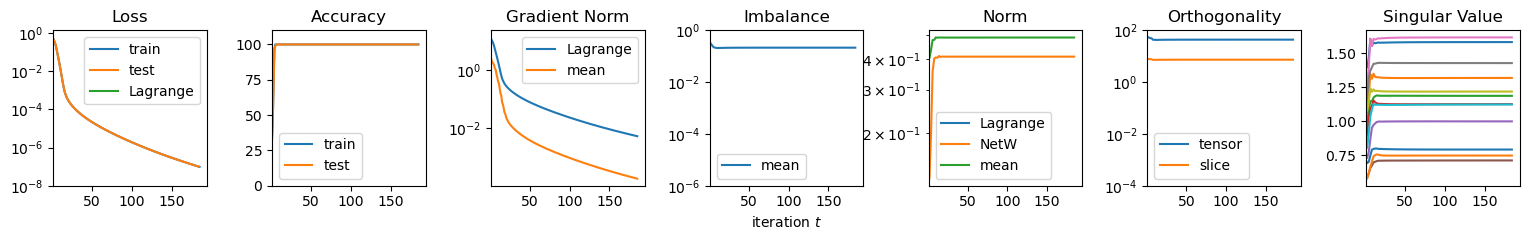

In [67]:
seed = 1
train_frac = 100
task_name = 'binary/x**2+y**2_mod'

out, save_name_quad1_100_seed1_noReg = train(task_name, train_frac, seed=seed,  val_check_interval=1, no_regularization=True)
(model_quad1_100_seed1_noReg, datamodule_quad1_100_seed1_noReg, trainer) = out

1
test/Lagrange/quad1_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5/seed1/frac=100.0


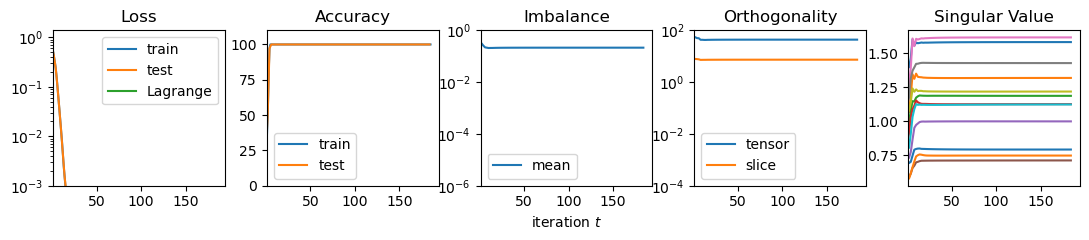

/Users/huh/Projects/grok/scripts/lightning_logs/test/Lagrange/quad1_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5/seed1/frac=100.0/version_2


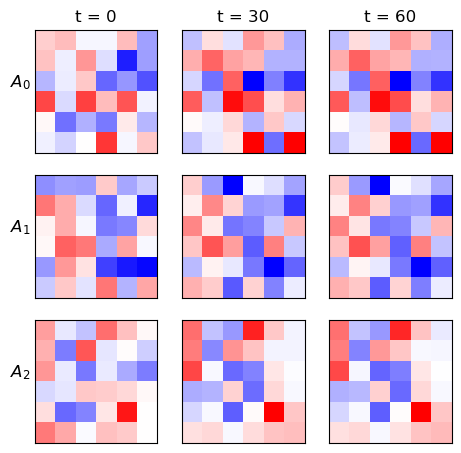

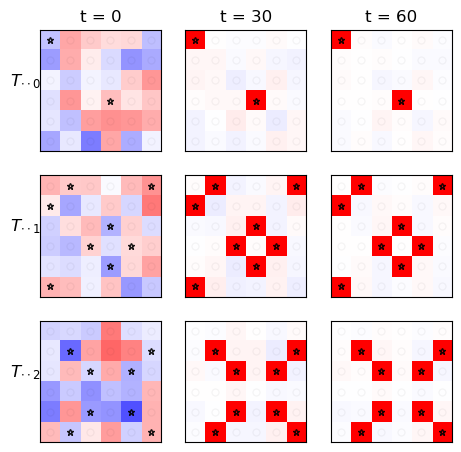

/Users/huh/Projects/grok/scripts/lightning_logs/test/Lagrange/quad1_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5/seed1/frac=100.0/version_2


In [73]:
_ = generate_figures(model_quad1_100_seed1_noReg, datamodule_quad1_100_seed1_noReg, save_name_quad1_100_seed2_noReg, 
                                                 skip=3, show_steps=2, XYZ_prev=XYZ_quad1_100_seed1, new_order=None, plot_all_weights=False)

#### 60%

##### R regularization

Missing logger folder: /Users/huh/Projects/grok/scripts/lightning_logs/test/Lagrange/quad1_6/FC_embed0/Alt_Optimizer momentum=0.0 customL2/lr=1.0 wd=0.1/seed5/frac=80.0


scheduler_criterion imbalance2/mean
train dataset size: 29 val dataset size: 7 ratio: 0.8055555555555556 %
current_step: 0 , max_step: 2500 , schedule: [0, 0, 0, 2500, 0]


/Users/huh/anaconda3/envs/grok_test/lib/python3.10/site-packages/pytorch_lightning/core/optimizer.py:331: RuntimeWarning: The lr scheduler dict contains the key(s) ['monitor', 'frequency'], but the keys will be ignored. You need to call `lr_scheduler.step()` manually in manual optimization.
  rank_zero_warn(


Sanity Checking: 0it [00:00, ?it/s]

/Users/huh/Projects/grok/grok/alt_opt.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_shape = torch.max(torch.tensor(max_shape), torch.tensor(a.shape))


Training: 0it [00:00, ?it/s]

1
test/Lagrange/quad1_6/FC_embed0/Alt_Optimizer momentum=0.0 customL2/lr=1.0 wd=0.1/seed5/frac=80.0


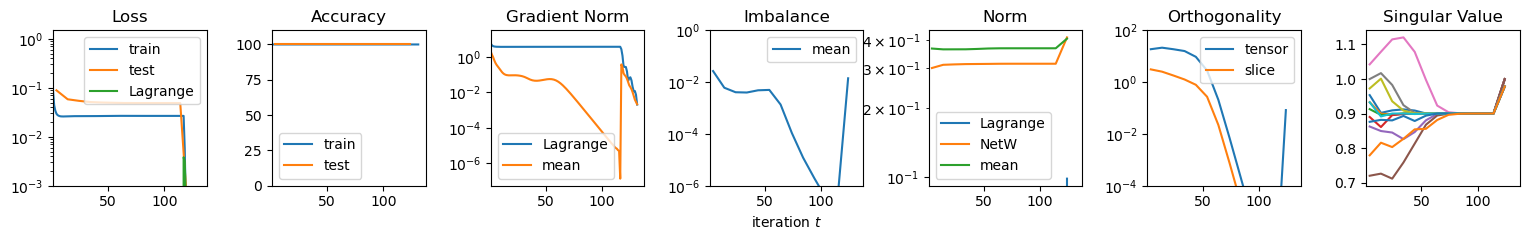

In [81]:
seed = 5
train_frac = 80
task_name = 'binary/x**2+y**2_mod'

out, save_name_quad1_61_seed1 = train(task_name, train_frac, seed=seed,   val_check_interval=5)
(model_quad1_61_seed1, datamodule_quad1_61_seed1, trainer) = out

1
test/Lagrange/quad1_6/FC_embed0/Alt_Optimizer momentum=0.0 customL2/lr=1.0 wd=0.1/seed5/frac=80.0


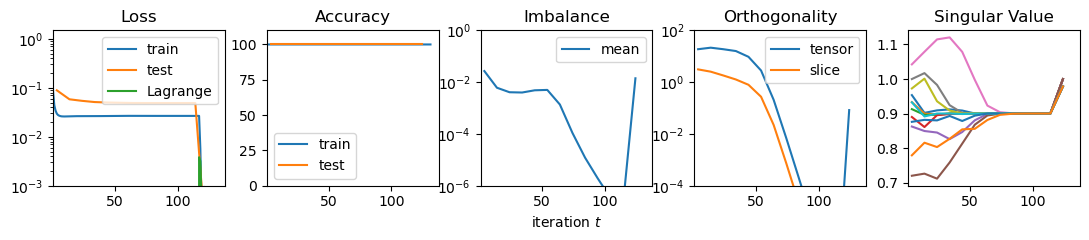

/Users/huh/Projects/grok/scripts/lightning_logs/test/Lagrange/quad1_6/FC_embed0/Alt_Optimizer momentum=0.0 customL2/lr=1.0 wd=0.1/seed5/frac=80.0/version_0


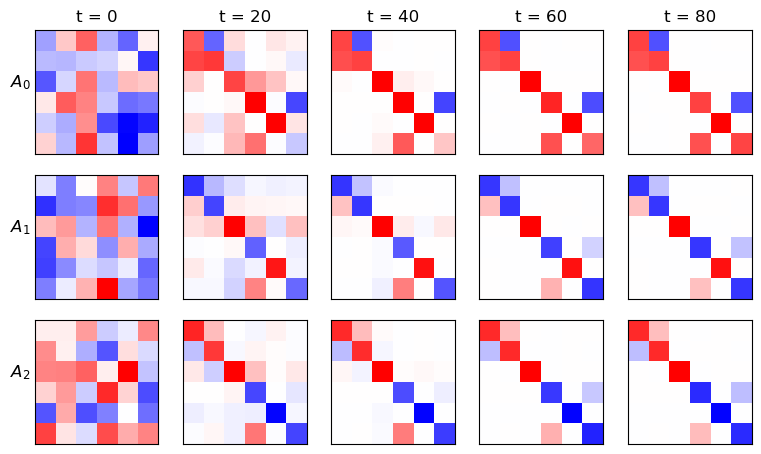

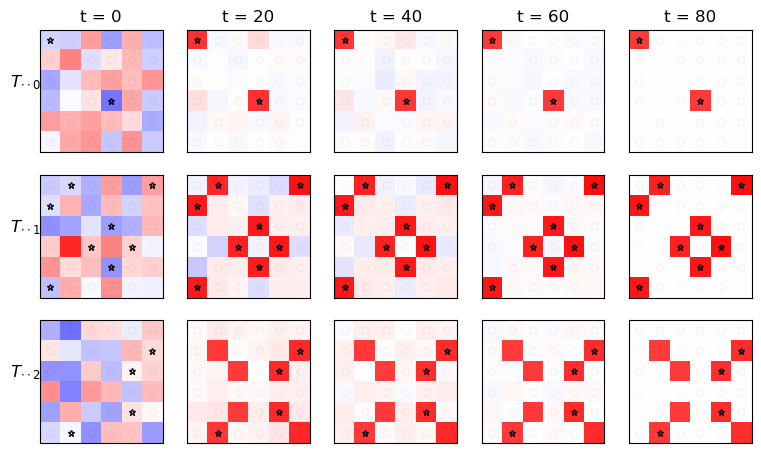

/Users/huh/Projects/grok/scripts/lightning_logs/test/Lagrange/quad1_6/FC_embed0/Alt_Optimizer momentum=0.0 customL2/lr=1.0 wd=0.1/seed5/frac=80.0/version_0


In [83]:
XYZ_quad1_61_seed1 = generate_figures(model_quad1_61_seed1, datamodule_quad1_61_seed1, save_name_quad1_61_seed1, 
                                                         skip=2, t_init=0, XYZ_prev=None, new_order=None) #[5,3,0,1,2,4])


##### no regularization

Missing logger folder: /Users/huh/Projects/grok/scripts/lightning_logs/test/Lagrange/quad1_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5/seed2/frac=61.0


scheduler_criterion imbalance2/mean
train dataset size: 22 val dataset size: 14 ratio: 0.6111111111111112 %
current_step: 0 , max_step: 2500 , schedule: [0, 0, 0, 2500, 0]


Sanity Checking: 0it [00:00, ?it/s]

/Users/huh/Projects/grok/grok/alt_opt.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  max_shape = torch.max(torch.tensor(max_shape), torch.tensor(a.shape))


Training: 0it [00:00, ?it/s]

1
test/Lagrange/quad1_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5/seed2/frac=61.0


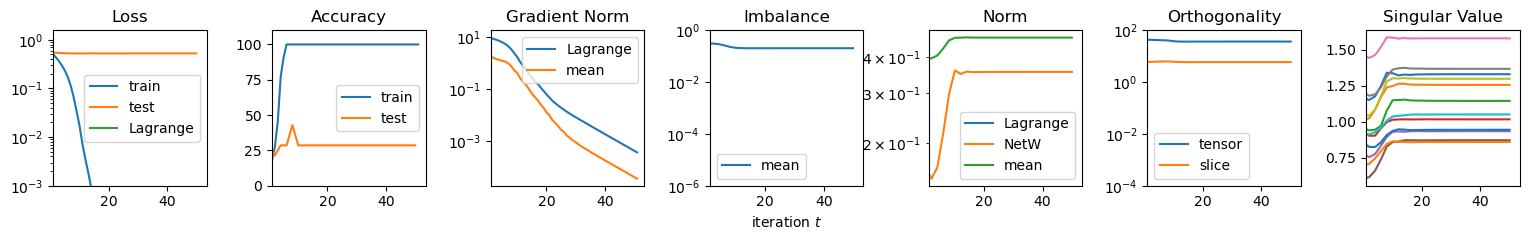

In [39]:
seed = 2
train_frac = 61
task_name = 'binary/x**2+y**2_mod'

out, save_name_quad1_61_seed2_noReg = train(task_name, train_frac, seed=seed,  val_check_interval=1, no_regularization=True)
(model_quad1_61_seed2_noReg, datamodule_quad1_61_seed2_noReg, trainer) = out

1
test/Lagrange/quad1_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5/seed2/frac=61.0


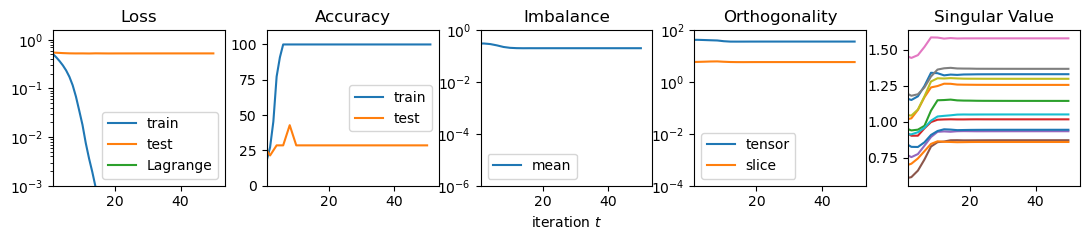

/Users/huh/Projects/grok/scripts/lightning_logs/test/Lagrange/quad1_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5/seed2/frac=61.0/version_0


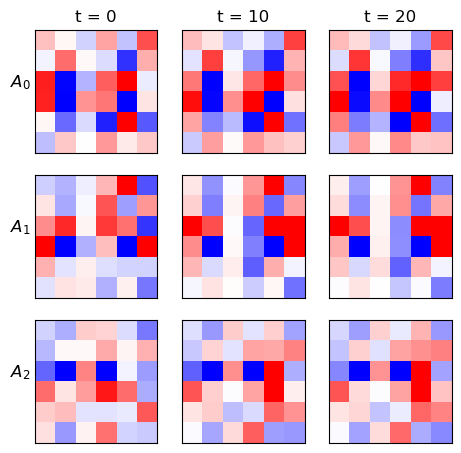

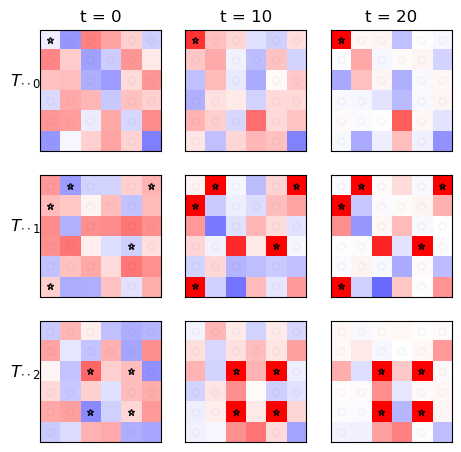

/Users/huh/Projects/grok/scripts/lightning_logs/test/Lagrange/quad1_6/FC_embed0/SGD momentum=0.5 customL2/lr=0.5/seed2/frac=61.0/version_0


In [40]:
_ = generate_figures(model_quad1_61_seed2_noReg, datamodule_quad1_61_seed2_noReg, save_name_quad1_61_seed2_noReg, 
                                                skip=1, show_steps = 2, XYZ_prev=XYZ_quad1_61_seed2, new_order=None)